In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [59]:
# %%bash

# #!/bin/bash

# experiments=('product' 'summation' 'negation')
# suffixes=('b1' 'b2' 'c1' 'c2')
# # 'a1' 'a2'

# for exp in "${experiments[@]}"
# do
#     for suffix in "${suffixes[@]}"
#     do
#         experiment_name="${exp}_${suffix}"
#         python ddpm.py --experiment_name "$experiment_name" --dataset "$experiment_name" --num_epochs 1000 --mlp_type energy > /dev/null 2>&1
#     done
# done

In [2]:
import torch
import ddpm
model_1 = ddpm.EnergyMLP()

model_2 = ddpm.EnergyMLP()

model_1.load_state_dict(torch.load("exps/product_a1/ema_model.pth"))
model_2.load_state_dict(torch.load("exps/product_a2/ema_model.pth"))

/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [59]:
from baselines import diffusion_baseline
model_to_test = model_1
samples = diffusion_baseline(model_to_test)
steps = np.arange(0, 50, 5)
diffusion_samples = np.array(samples)[steps]

100%|██████████| 50/50 [00:00<00:00, 468.93it/s]


In [60]:
from baselines import ebm_baseline
model_to_test = model_1
samples = ebm_baseline(model_to_test)
steps = np.arange(0, 50, 5)
ebm_samples = np.array(samples)[steps]

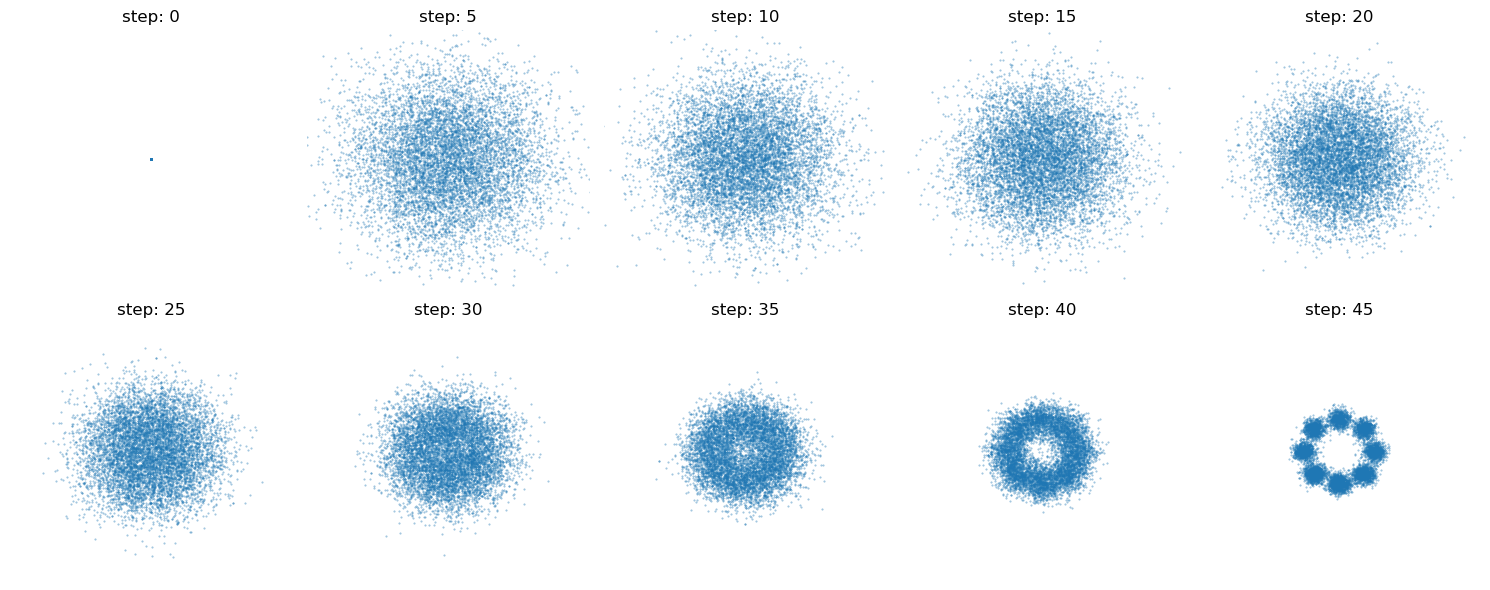

In [64]:
import matplotlib.pyplot as plt
import math
samples_to_draw = ebm_samples

plt.clf()
plt.close('all')
num_cols = 5
num_rows = math.ceil(len(samples_to_draw) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples_to_draw):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=0.2)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.axis("off")
fig.tight_layout()
# plt.savefig('figures/composition_hmc_product.png')

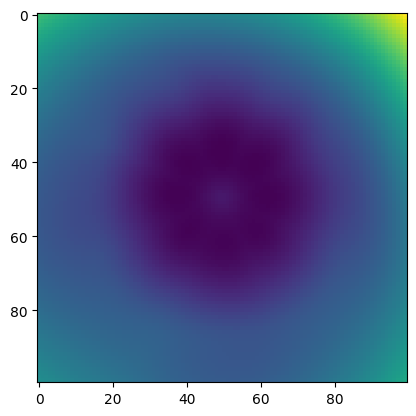

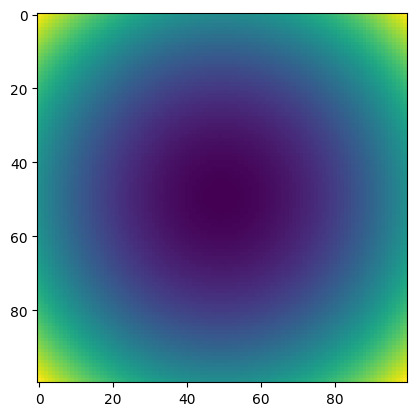

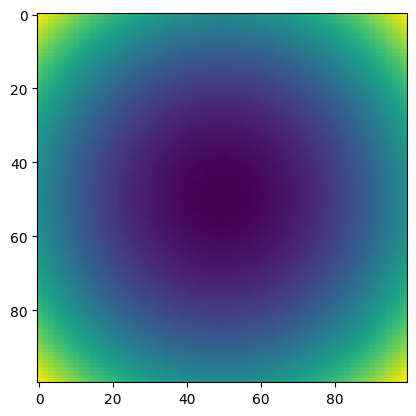

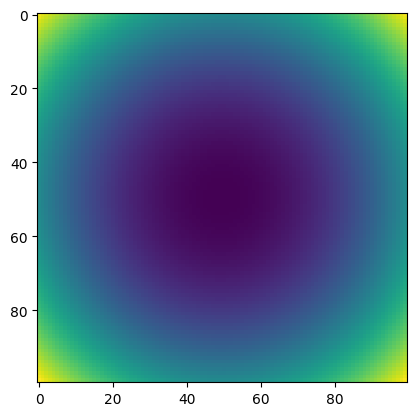

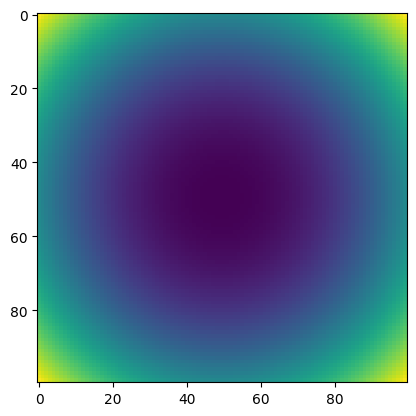

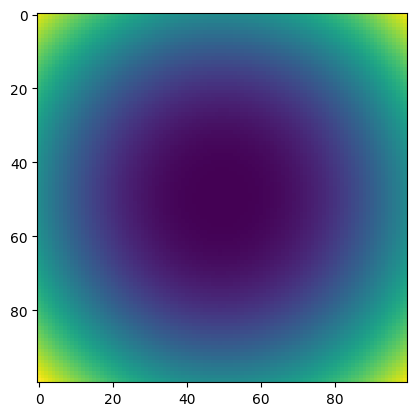

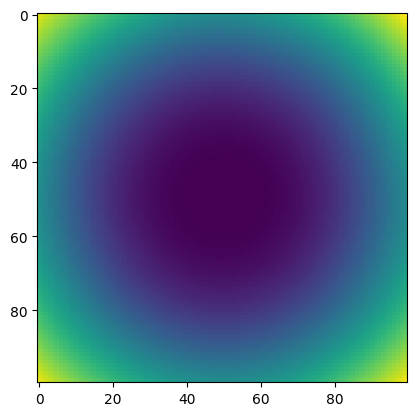

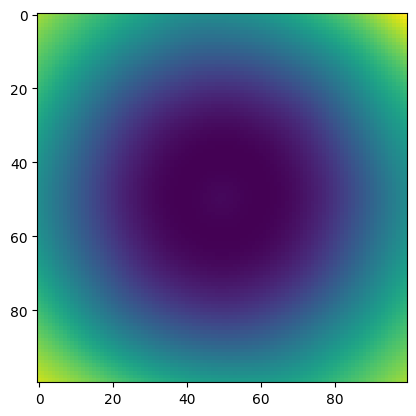

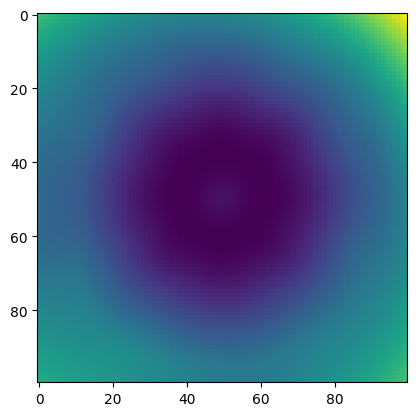

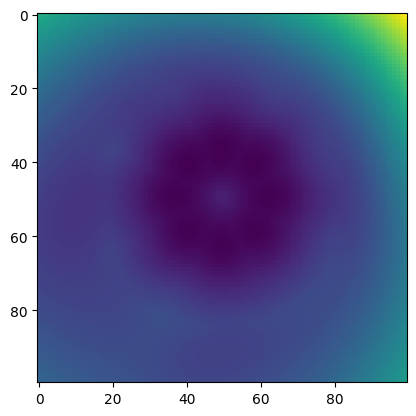

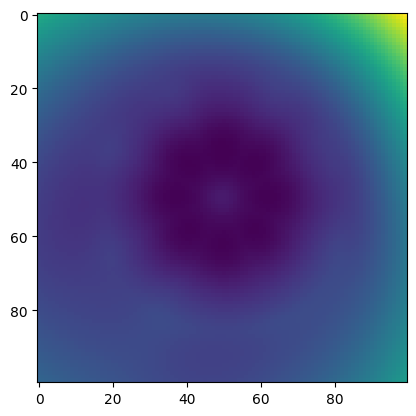

In [51]:
# draw the energy landscape
import matplotlib.pyplot as plt
import numpy as np

# model_to_test = CompositionEnergyMLP(model_1.cuda(), model_2.cuda(), algebra='product')
model_to_test = model_1.cuda()

plt.clf()
plt.close('all')
for t in range(50, -1, -5):
    # meshgrid the space
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    Z = model_to_test.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
    plt.imshow(Z)
    plt.show()

plt.clf()
plt.close('all')

# W2 distance

In [ ]:
import ot
from datasets import generate_data_points
from baselines import evaluate_W2

generated_samples = ebm_samples[-1]
dataset = generate_data_points(n=8000, dataset='product_a1')
w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset)

print("Wasserstein-2 distance:", w2_distance)

In [73]:
samples = ebm_baseline(model_to_test)
dataset = generate_data_points(n=8000, dataset='product_a1')
w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset)

print("Wasserstein-2 distance:", w2_distance)

Wasserstein-2 distance: 0.003003201015293597


# W2 distance for last energy piece

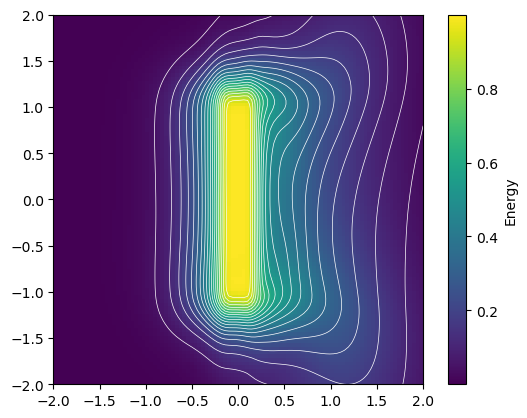

In [8]:
# draw the energy landscape
import matplotlib.pyplot as plt
import numpy as np

# model_to_test = CompositionEnergyMLP(model_1.cuda(), model_2.cuda(), algebra='product')
model_to_test = model_2.cuda()

plt.clf()
plt.close('all')
t = 0
# meshgrid the space
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
Z = model_to_test.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
Z = np.exp(-Z)
plt.imshow(Z.reshape(100, 100), extent=[-2, 2, -2, 2])
plt.colorbar(label='Energy')

# Add level sets
levels = np.linspace(Z.min(), Z.max(), 20)  # Adjust the number of levels as needed
plt.contour(X, Y, Z, levels=levels, colors='white', linewidths=0.5)

plt.show()

plt.clf()
plt.close('all')

In [9]:
from datasets import generate_data_points
import ot
mass = Z / Z.sum()
points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
mass = mass.reshape(-1)
target_samples = generate_data_points(n=10000, dataset='product_a2')
cost_matrix = ot.dist(points, target_samples, metric='sqeuclidean')
# Calculate the Wasserstein-2 distance using the optimal transport plan
w2_distance = ot.emd2(mass,
                    np.ones(len(target_samples)) / len(target_samples),
                    cost_matrix,
                    numItermax=int(1e7))
print(w2_distance)

0.5865770299402167


In [11]:
# reduce the non-support region
from datasets import generate_data_points
import ot
from bootstrapping import bootstrapping_and_get_max
import torch
import numpy as np

model_to_test = ddpm.EnergyMLP().cuda()
for environment in ['product_a1', 'product_a2', 'summation_a1', 'summation_a2', 'negation_a1', 'negation_a2']:

    model_to_test.load_state_dict(torch.load(f"exps/{environment}/ema_model.pth"))
    target_samples = generate_data_points(n=10000, dataset=environment)
    
    # calculate the level-set values
    with torch.no_grad():
        energy_on_data = model_to_test.energy(torch.from_numpy(target_samples).cuda(), torch.zeros(len(target_samples)).long().cuda())
    extreme_value = bootstrapping_and_get_max(energy_on_data.cpu().numpy())
    # calibrate energy
    Z = model_to_test.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
    Z[Z>extreme_value] = np.inf
    Z = np.exp(-Z)
    mass = Z / Z.sum()
    points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
    mass = mass.reshape(-1)
    cost_matrix = ot.dist(points, target_samples, metric='sqeuclidean')
    # Calculate the Wasserstein-2 distance using the optimal transport plan
    w2_distance = ot.emd2(mass,
                        np.ones(len(target_samples)) / len(target_samples),
                        cost_matrix,
                        numItermax=int(1e7))
    print(f'environment: {environment}, temperature: distilled, w2_distance: {w2_distance}')
    
    # increase the temperature
    for temperature in [0.1, 0.3, 0.6, 1., 4., 16., 256., 1000.]:
        Z = model_to_test.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
        Z = Z * temperature
        Z = np.exp(-Z)
        mass = Z / Z.sum()
        mass = mass.reshape(-1)
        points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
        cost_matrix = ot.dist(points, target_samples, metric='sqeuclidean')
        # Calculate the Wasserstein-2 distance using the optimal transport plan
        w2_distance = ot.emd2(mass,
                            np.ones(len(target_samples)) / len(target_samples),
                            cost_matrix,
                            numItermax=int(1e7))
        print(f'environment: {environment}, temperature: {temperature}, w2_distance: {w2_distance}')

calculating bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 11946.79it/s]


environment: product_a1, temperature: distilled, w2_distance: 0.027173781212270355
environment: product_a1, temperature: 0.1, w2_distance: 1.2515959161835661
environment: product_a1, temperature: 0.3, w2_distance: 0.9896227774371715
environment: product_a1, temperature: 0.6, w2_distance: 0.6884283953508826
environment: product_a1, temperature: 1.0, w2_distance: 0.4082599031107598
environment: product_a1, temperature: 4.0, w2_distance: 0.027956405686752638
environment: product_a1, temperature: 16.0, w2_distance: 0.04560557991863538
environment: product_a1, temperature: 256.0, w2_distance: 0.47616786362748115
environment: product_a1, temperature: 1000.0, w2_distance: 0.5004391133199972


calculating bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 12326.15it/s]


environment: product_a2, temperature: distilled, w2_distance: 0.0005546069221657239
environment: product_a2, temperature: 0.1, w2_distance: 1.3890086496704543
environment: product_a2, temperature: 0.3, w2_distance: 1.1199970559715835
environment: product_a2, temperature: 0.6, w2_distance: 0.8453954193411584
environment: product_a2, temperature: 1.0, w2_distance: 0.5843293667801878
environment: product_a2, temperature: 4.0, w2_distance: 0.038853866499961205
environment: product_a2, temperature: 16.0, w2_distance: 0.00204876991702982
environment: product_a2, temperature: 256.0, w2_distance: 0.01363179221786869
environment: product_a2, temperature: 1000.0, w2_distance: 0.06921740342481676


calculating bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 12276.54it/s]


environment: summation_a1, temperature: distilled, w2_distance: 0.005582127472388962
environment: summation_a1, temperature: 0.1, w2_distance: 1.5872334409268603
environment: summation_a1, temperature: 0.3, w2_distance: 0.9954543993721332
environment: summation_a1, temperature: 0.6, w2_distance: 0.49093561592487495
environment: summation_a1, temperature: 1.0, w2_distance: 0.22342235323363263
environment: summation_a1, temperature: 4.0, w2_distance: 0.028735378469036017
environment: summation_a1, temperature: 16.0, w2_distance: 0.00511235834301918
environment: summation_a1, temperature: 256.0, w2_distance: 0.0035770062376131507
environment: summation_a1, temperature: 1000.0, w2_distance: 0.04523025417188954


calculating bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 12393.78it/s]


environment: summation_a2, temperature: distilled, w2_distance: 0.005291539747058519
environment: summation_a2, temperature: 0.1, w2_distance: 1.695142988654191
environment: summation_a2, temperature: 0.3, w2_distance: 1.2716245865330271
environment: summation_a2, temperature: 0.6, w2_distance: 0.8215094859253723
environment: summation_a2, temperature: 1.0, w2_distance: 0.4427120434804596
environment: summation_a2, temperature: 4.0, w2_distance: 0.03076432703153457
environment: summation_a2, temperature: 16.0, w2_distance: 0.005505698412136613
environment: summation_a2, temperature: 256.0, w2_distance: 0.0027138967880586573
environment: summation_a2, temperature: 1000.0, w2_distance: 0.037756733431925926


calculating bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 12268.03it/s]


environment: negation_a1, temperature: distilled, w2_distance: 0.0021021983845417535
environment: negation_a1, temperature: 0.1, w2_distance: 0.6051165168387718
environment: negation_a1, temperature: 0.3, w2_distance: 0.45753519002672266
environment: negation_a1, temperature: 0.6, w2_distance: 0.30387310691900365
environment: negation_a1, temperature: 1.0, w2_distance: 0.1853048421374096
environment: negation_a1, temperature: 4.0, w2_distance: 0.0294697984276323
environment: negation_a1, temperature: 16.0, w2_distance: 0.004159694184903997
environment: negation_a1, temperature: 256.0, w2_distance: 0.05566642944224108
environment: negation_a1, temperature: 1000.0, w2_distance: 0.2283714007302816


calculating bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 12356.03it/s]


environment: negation_a2, temperature: distilled, w2_distance: 0.0014092941590664182
environment: negation_a2, temperature: 0.1, w2_distance: 1.3826308070750444
environment: negation_a2, temperature: 0.3, w2_distance: 1.1066089897697513
environment: negation_a2, temperature: 0.6, w2_distance: 0.7923698497391658
environment: negation_a2, temperature: 1.0, w2_distance: 0.5169502114420522
environment: negation_a2, temperature: 4.0, w2_distance: 0.058936328579351036
environment: negation_a2, temperature: 16.0, w2_distance: 0.0038499647972168195
environment: negation_a2, temperature: 256.0, w2_distance: 0.013138613248637208
environment: negation_a2, temperature: 1000.0, w2_distance: 0.08026845319261737


# W2 distance for last energy piece (for composed energy values)

In [14]:
# reduce the non-support region
from datasets import generate_data_points
import ot
from bootstrapping import bootstrapping_and_get_max
import torch
import numpy as np

model_1 = ddpm.EnergyMLP().cuda()
model_2 = ddpm.EnergyMLP().cuda()

model_to_test = ddpm.EnergyMLP().cuda()

for environment in ['product', 'summation', 'negation']:
    for calibrate in [False, True]:

        model_1.load_state_dict(torch.load(f"exps/{environment}_a1/ema_model.pth"))
        model_2.load_state_dict(torch.load(f"exps/{environment}_a2/ema_model.pth"))
        
        target_samples = generate_data_points(n=10000, dataset=f'{environment}_a1')
        # calculate the level-set values
        with torch.no_grad():
            energy_on_data = model_1.energy(torch.from_numpy(target_samples).cuda(), torch.zeros(len(target_samples)).long().cuda())
        Z1_extreme = bootstrapping_and_get_max(energy_on_data.cpu().numpy())
        
        target_samples = generate_data_points(n=10000, dataset=f'{environment}_a2')
        # calculate the level-set values
        with torch.no_grad():
            energy_on_data = model_2.energy(torch.from_numpy(target_samples).cuda(), torch.zeros(len(target_samples)).long().cuda())
        Z2_extreme = bootstrapping_and_get_max(energy_on_data.cpu().numpy())
        
        # calibrate energy
        Z1 = model_1.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(), torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
        Z2 = model_2.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(), torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
        if environment == 'product':
            Z = Z1 + Z2
            if calibrate:
                Z[(Z1 > Z1_extreme) | (Z2 > Z2_extreme)] = np.inf
        elif environment == 'summation':
            Z = -np.logaddexp(-3.5*Z1, -3.5*Z2)
            if calibrate:
                Z[(Z1 > Z1_extreme) & (Z2 > Z2_extreme)] = np.inf
        elif environment == 'negation':
            Z = 1.3 * Z1 - 0.3 * Z2
            if calibrate:
                Z[(Z1 > Z1_extreme) | (Z2 < Z2_extreme)] = np.inf
        Z = np.exp(-Z)
        mass = Z / Z.sum()
        points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
        mass = mass.reshape(-1)
        target_samples = generate_data_points(n=10000, dataset=f'{environment}_a3')
        cost_matrix = ot.dist(points, target_samples, metric='sqeuclidean')
        # Calculate the Wasserstein-2 distance using the optimal transport plan
        w2_distance = ot.emd2(mass,
                            np.ones(len(target_samples)) / len(target_samples),
                            cost_matrix,
                            numItermax=int(1e7))
        print(f'environment: {environment}, temperature: distilled, calibrate: {calibrate}, w2_distance: {w2_distance}')

environment: product, temperature: distilled, calibrate: False, w2_distance: 0.24887770278776034
environment: product, temperature: distilled, calibrate: True, w2_distance: 0.061323319342071296
environment: summation, temperature: distilled, calibrate: False, w2_distance: 0.03048469212985988
environment: summation, temperature: distilled, calibrate: True, w2_distance: 0.0050939496081742865
environment: negation, temperature: distilled, calibrate: False, w2_distance: 0.16588835879684374
environment: negation, temperature: distilled, calibrate: True, w2_distance: 0.0038866214662658266


# W2 distance for energy piece through all timestep (for composed energy values)

In [19]:
# reduce the non-support region
from datasets import generate_data_points
from baselines import intermediate_distribution
import ot
import ddpm
from bootstrapping import bootstrapping_and_get_max, bootstrapping_and_get_interval
import torch
import numpy as np

model_1 = ddpm.EnergyMLP().cuda()
model_2 = ddpm.EnergyMLP().cuda()

# meshgrid the space
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

model_to_test = ddpm.EnergyMLP().cuda()
for environment in ['product', 'summation', 'negation']:
    for calibrate in [False, True]:

        model_1.load_state_dict(torch.load(f"exps/{environment}_a1/ema_model.pth"))
        model_2.load_state_dict(torch.load(f"exps/{environment}_a2/ema_model.pth"))
        
        target_samples_1 = generate_data_points(n=10000, dataset=f'{environment}_a1')
        intermediate_samples_1 = intermediate_distribution(target_samples_1)[1:]
        target_samples_2 = generate_data_points(n=10000, dataset=f'{environment}_a2')
        intermediate_samples_2 = intermediate_distribution(target_samples_2)[1:]
        target_samples_3 = generate_data_points(n=10000, dataset=f'{environment}_a3')
        intermediate_samples_3 = intermediate_distribution(target_samples_3)[1:]

        for t in range(49, -1, -1):
            target_samples_1 = intermediate_samples_1[49-t]
            target_samples_2 = intermediate_samples_2[49-t]
            target_samples_3 = intermediate_samples_3[49-t]
            
            # calculate the level-set values
            with torch.no_grad():
                energy_on_data = model_1.energy(torch.from_numpy(target_samples_1).cuda(), t+torch.zeros(len(target_samples_1)).long().cuda())
            Z1_extreme_min, Z1_extreme_max = bootstrapping_and_get_interval(energy_on_data.cpu().numpy())
            
            # calculate the level-set values
            with torch.no_grad():
                energy_on_data = model_2.energy(torch.from_numpy(target_samples_2).cuda(), t+torch.zeros(len(target_samples_2)).long().cuda())
            Z2_extreme_min, Z2_extreme_max = bootstrapping_and_get_interval(energy_on_data.cpu().numpy())
            
            # calibrate energy
            Z1 = model_1.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
            Z2 = model_2.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
            if environment == 'product':
                Z = Z1 + Z2
                if calibrate:
                    need_to_remove = (Z1 > Z1_extreme_max) | (Z2 > Z2_extreme_max)
            elif environment == 'summation':
                Z = -np.logaddexp(-3.5*Z1, -3.5*Z2)
                if calibrate:
                    need_to_remove = (Z1 > Z1_extreme_max) & (Z2 > Z2_extreme_max)
            elif environment == 'negation':
                Z = 1.3 * Z1 - 0.3 * Z2
                if calibrate:
                    need_to_remove = (Z1 > Z1_extreme_max) | (Z2 < Z2_extreme_max)
            
            if calibrate and (need_to_remove.sum() != 10000):
                Z[need_to_remove] = np.inf
            
            Z = np.exp(-Z)
            mass = Z / Z.sum()
            points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
            mass = mass.reshape(-1)
            
            cost_matrix = ot.dist(points, target_samples_3, metric='sqeuclidean')
            # Calculate the Wasserstein-2 distance using the optimal transport plan
            w2_distance = ot.emd2(mass,
                                np.ones(len(target_samples_3)) / len(target_samples_3),
                                cost_matrix,
                                numItermax=int(1e7))
            print(f'environment: {environment}, timestep:{t}, temperature: distilled, calibrate: {calibrate}, w2_distance: {w2_distance}, filtered_ratio: {(Z==0).mean()}')

environment: product, timestep:49, temperature: distilled, calibrate: False, w2_distance: 0.011618232229988267, filtered_ratio: 0.0
environment: product, timestep:48, temperature: distilled, calibrate: False, w2_distance: 0.008786652584400239, filtered_ratio: 0.0
environment: product, timestep:47, temperature: distilled, calibrate: False, w2_distance: 0.0060221041202561205, filtered_ratio: 0.0
environment: product, timestep:46, temperature: distilled, calibrate: False, w2_distance: 0.006878077096210689, filtered_ratio: 0.0
environment: product, timestep:45, temperature: distilled, calibrate: False, w2_distance: 0.0058202111375454165, filtered_ratio: 0.0
environment: product, timestep:44, temperature: distilled, calibrate: False, w2_distance: 0.0042034857493680735, filtered_ratio: 0.0
environment: product, timestep:43, temperature: distilled, calibrate: False, w2_distance: 0.004388511391503702, filtered_ratio: 0.0
environment: product, timestep:42, temperature: distilled, calibrate: Fal

# Rejection Sampling based on Energy Value at Last Timestep

In [21]:
# compare EBM with normal diffusion

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, evaluate_W2
from datasets import generate_data_points


def calculate_threshold(samples, model, confidence=0.999):
    # calculate the level-set values
    with torch.no_grad():
        energy_on_data = model.energy(torch.from_numpy(samples).cuda(), torch.zeros(len(samples)).long().cuda())
    extreme_value = bootstrapping_and_get_max(energy_on_data.cpu().numpy(), confidence=confidence)
    return extreme_value

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()

method_fn = ebm_baseline
eval_batch_size = 10000
for algebra in ['product', 'summation', 'negation']:
    environment = algebra + '_' + 'a3'
    model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
    model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
    model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
    generated_samples = method_fn(model_to_test, eval_batch_size=eval_batch_size)[-1]

    dataset_1 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a1')
    dataset_2 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a2')
    Z1_extreme = calculate_threshold(dataset_1, model_1)
    Z2_extreme = calculate_threshold(dataset_2, model_2)

    # evaluate generated_samples on energy
    Z1 = model_1.energy(torch.from_numpy(generated_samples).cuda().float(), torch.zeros(len(generated_samples)).long().cuda()).detach().cpu().numpy()
    Z2 = model_2.energy(torch.from_numpy(generated_samples).cuda().float(), torch.zeros(len(generated_samples)).long().cuda()).detach().cpu().numpy()
    if algebra == 'product':
        new_generated_samples = generated_samples[(Z1 < Z1_extreme) & (Z2 < Z2_extreme)]
    elif algebra == 'summation':
        new_generated_samples = generated_samples[(Z1 < Z1_extreme) | (Z2 < Z2_extreme)]
    elif algebra == 'negation':
        new_generated_samples = generated_samples[(Z1 < Z1_extreme) & (Z2 > Z2_extreme)]
    
    dataset = generate_data_points(n=eval_batch_size, dataset=environment)
    previous_w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset)
    new_w2_distance = evaluate_W2(generated_samples=new_generated_samples, target_samples=dataset)
    
    print(f"{environment}, original Wasserstein-2 distance: {previous_w2_distance}, filtered Wasserstein-2 distance: {new_w2_distance}, sample ratio: {len(new_generated_samples)/len(generated_samples)}")

100%|██████████| 490/490 [00:15<00:00, 31.26it/s]


product_a3, original Wasserstein-2 distance: 0.018890825273096552, filtered Wasserstein-2 distance: 0.019013850671698487, sample ratio: 0.9997


100%|██████████| 490/490 [00:15<00:00, 30.99it/s]


summation_a3, original Wasserstein-2 distance: 0.004713924844502479, filtered Wasserstein-2 distance: 0.004713924844502479, sample ratio: 1.0


100%|██████████| 490/490 [00:15<00:00, 31.01it/s]


negation_a3, original Wasserstein-2 distance: 0.2415049368202697, filtered Wasserstein-2 distance: 0.36226172647056865, sample ratio: 0.6809


# Rejection Sampling based on Energy Value through Multiple Timestep

100%|██████████| 50/50 [00:01<00:00, 29.92it/s]


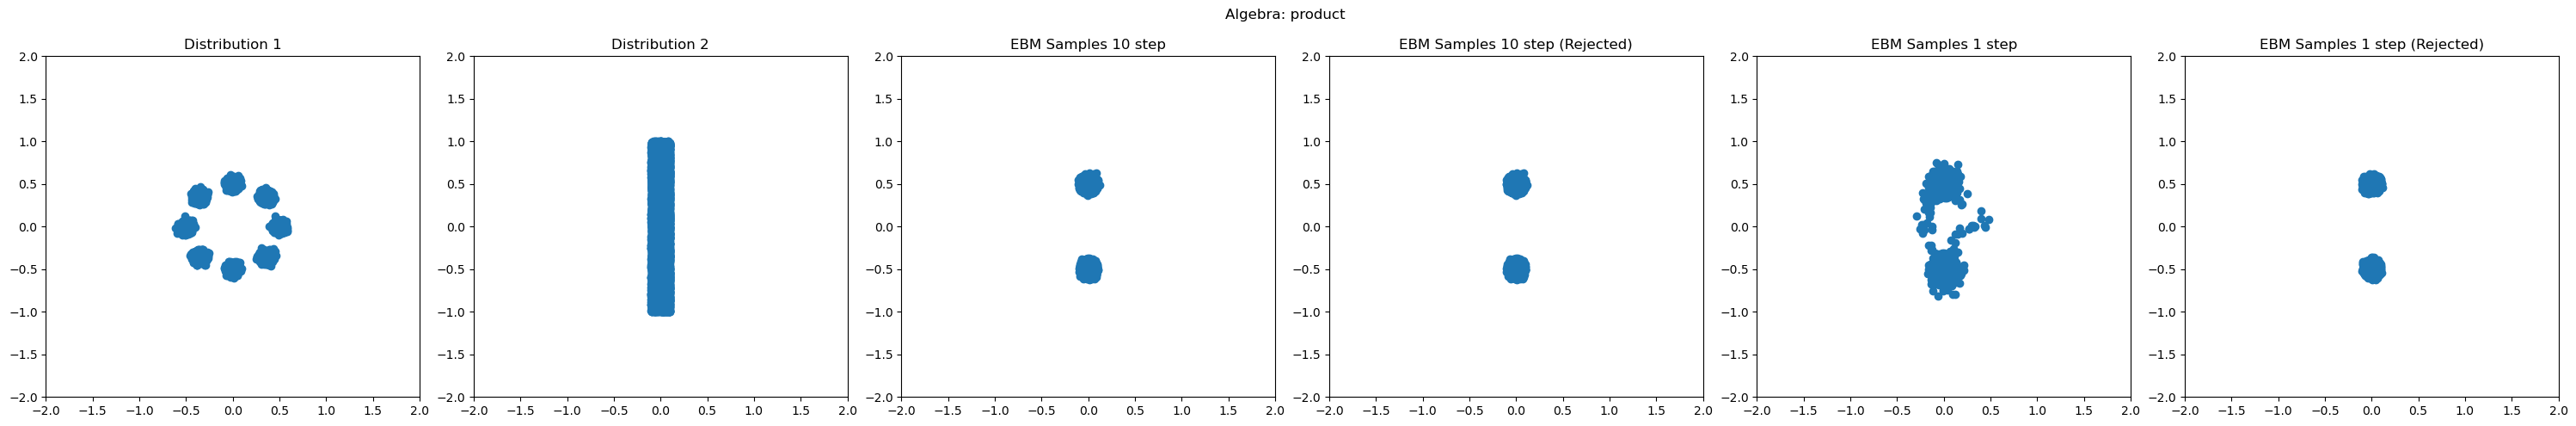

product_a3, original Wasserstein-2 distance: 0.018920039266347825, filtered Wasserstein-2 distance: 0.039407010923325936, 1-step Wasserstein-2 distance: 0.007820020075142396, filtered 1-step Wasserstein-2 distance: 0.017492662550508867, sample ratio: 1.0


100%|██████████| 50/50 [00:01<00:00, 29.70it/s]


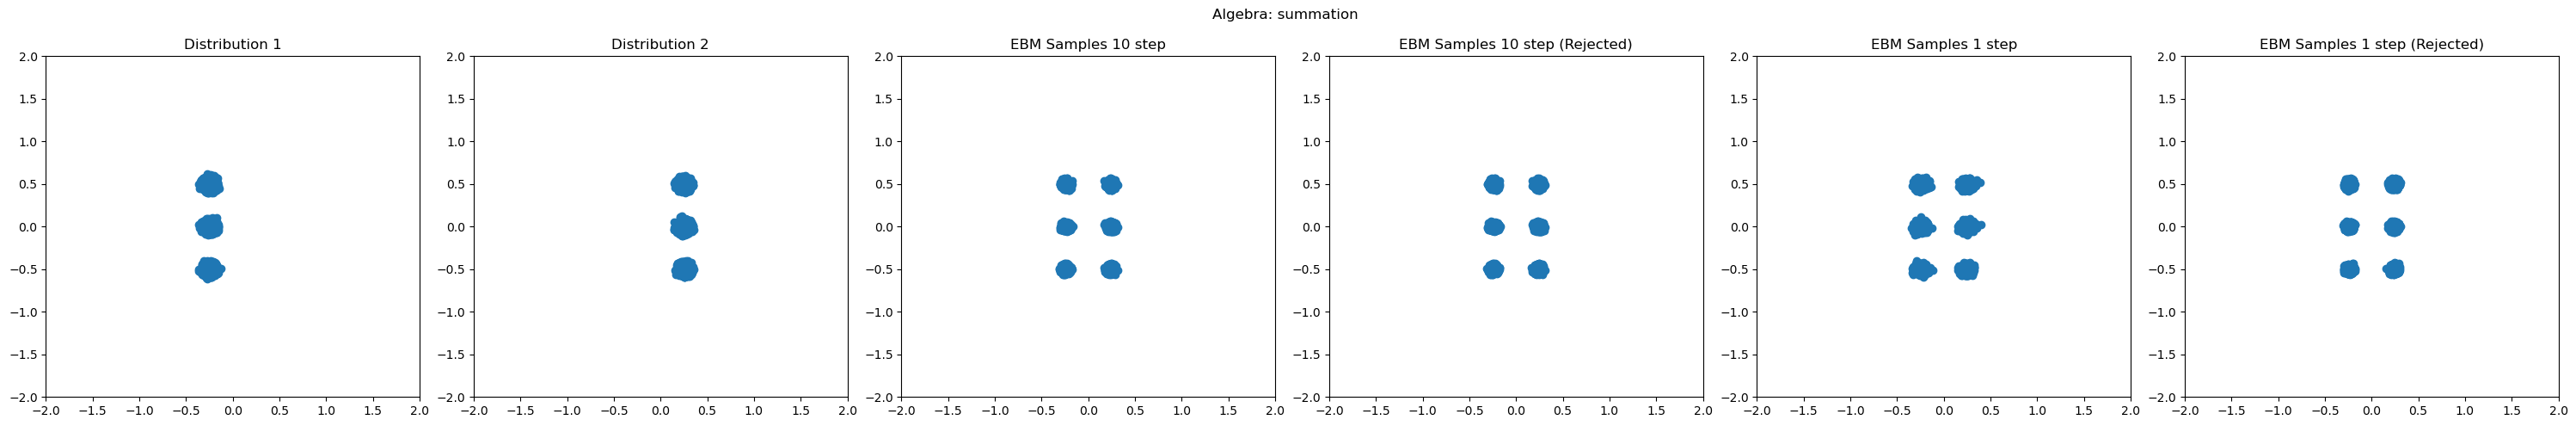

summation_a3, original Wasserstein-2 distance: 0.004971676856889534, filtered Wasserstein-2 distance: 0.0041000835283784174, 1-step Wasserstein-2 distance: 0.014472809919234697, filtered 1-step Wasserstein-2 distance: 0.014560552921383682, sample ratio: 1.0


100%|██████████| 50/50 [00:01<00:00, 29.66it/s]


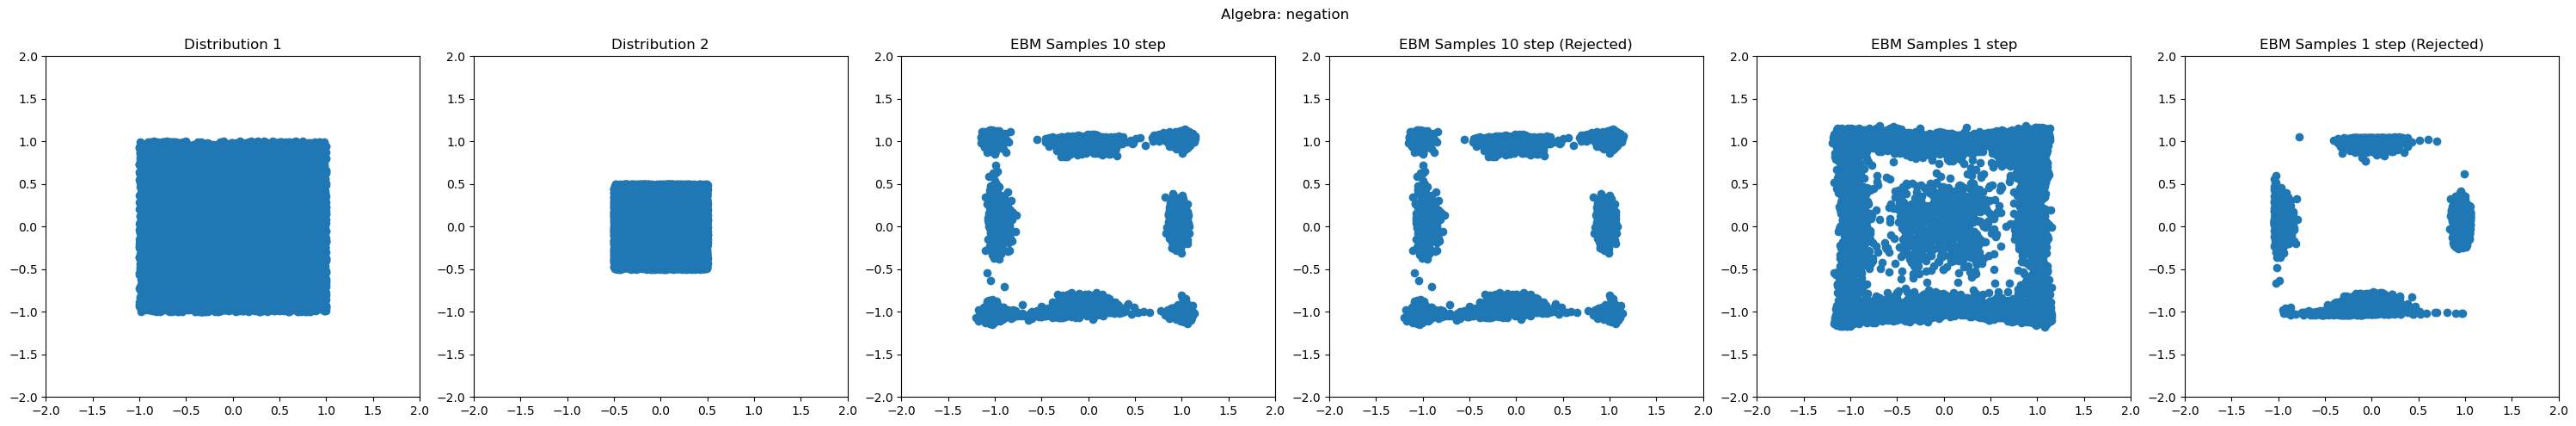

negation_a3, original Wasserstein-2 distance: 0.2455896830320352, filtered Wasserstein-2 distance: 0.39121714786588974, 1-step Wasserstein-2 distance: 0.0998035535439852, filtered 1-step Wasserstein-2 distance: 0.07539946321249005, sample ratio: 1.0


In [38]:
# compare EBM with normal diffusion

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, ebm_rejection_baseline, evaluate_W2
from datasets import generate_data_points
from r_and_r import calculate_threshold_multiple_timesteps, calculate_interval_multiple_timesteps, calculate_interval_to_avoid_multiple_timesteps

model_1 = ddpm.EnergyMLP().cuda()
model_2 = ddpm.EnergyMLP().cuda()

eval_batch_size = 10000
for algebra in ['product', 'summation', 'negation']:
    environment = algebra + '_' + 'a3'
    model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
    model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
    model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)

    dataset_1 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a1')
    dataset_2 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a2')
    dataset_3 = generate_data_points(n=eval_batch_size, dataset=environment)

    intervals_1 = calculate_interval_multiple_timesteps(samples=dataset_1, model=model_1)
    if algebra=='negation':
        intervals_2 = calculate_interval_to_avoid_multiple_timesteps(samples_to_reach=dataset_3, samples_to_avoid=dataset_2, model=model_2)
    else:
        intervals_2 = calculate_interval_multiple_timesteps(samples=dataset_2, model=model_2)

    generated_samples = ebm_baseline(model_to_test,
                                     eval_batch_size=eval_batch_size)[-1]

    new_generated_samples, filter_ratios = ebm_rejection_baseline(composed_model=model_to_test,
                                               models=[model_1, model_2],
                                               algebra=algebra,
                                               intervals=[intervals_1, intervals_2],
                                               eval_batch_size=eval_batch_size)
    new_generated_samples = new_generated_samples[-1]    

    generated_samples_1_step = ebm_baseline(model_to_test,
                                     samples_per_step=1,
                                     eval_batch_size=eval_batch_size)[-1]
    
    new_generated_samples_1_step, filter_ratios = ebm_rejection_baseline(composed_model=model_to_test,
                                               models=[model_1, model_2], 
                                               algebra=algebra,
                                               intervals=[intervals_1, intervals_2],
                                               samples_per_step=1,
                                               eval_batch_size=eval_batch_size)
    new_generated_samples_1_step = new_generated_samples_1_step[-1]

    plt.close('all')
    
    fig, axes = plt.subplots(1, 6, figsize=(30, 5))

    axes[0].scatter(*dataset_1.T)
    axes[0].set_xlim(-2, 2)
    axes[0].set_ylim(-2, 2)
    axes[0].set_title('Distribution 1')
    
    axes[1].scatter(*dataset_2.T)
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    axes[1].set_title('Distribution 2')
    
    axes[2].scatter(*generated_samples.T)
    axes[2].set_xlim(-2, 2)
    axes[2].set_ylim(-2, 2)
    axes[2].set_title('EBM Samples 10 step')

    axes[3].scatter(*generated_samples.T)
    axes[3].set_xlim(-2, 2)
    axes[3].set_ylim(-2, 2)
    axes[3].set_title('EBM Samples 10 step (Rejected)')    

    axes[4].scatter(*generated_samples_1_step.T)
    axes[4].set_xlim(-2, 2)
    axes[4].set_ylim(-2, 2)
    axes[4].set_title('EBM Samples 1 step')    
    
    axes[5].scatter(*new_generated_samples.T)
    axes[5].set_xlim(-2, 2)
    axes[5].set_ylim(-2, 2)
    axes[5].set_title('EBM Samples 1 step (Rejected)')
    
    fig.suptitle(f'Algebra: {algebra}')
    
    plt.tight_layout()
    plt.savefig(f'figures/filtering_ebm_multiple_t_{algebra}')
    plt.show()   
    
    previous_w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset_3)
    new_w2_distance = evaluate_W2(generated_samples=new_generated_samples, target_samples=dataset_3)
    previous_w2_distance_1_step = evaluate_W2(generated_samples=generated_samples_1_step, target_samples=dataset_3)
    new_w2_distance_1_step = evaluate_W2(generated_samples=new_generated_samples_1_step, target_samples=dataset_3)
    
    print(f"{environment}, original Wasserstein-2 distance: {previous_w2_distance}, filtered Wasserstein-2 distance: {new_w2_distance}, 1-step Wasserstein-2 distance: {previous_w2_distance_1_step}, filtered 1-step Wasserstein-2 distance: {new_w2_distance_1_step}, sample ratio: {len(new_generated_samples)/len(generated_samples)}")

# Rejection Sampling for Samples from Diffusion Models on Energy Value at Last Timestep

100%|██████████| 50/50 [00:00<00:00, 199.72it/s]


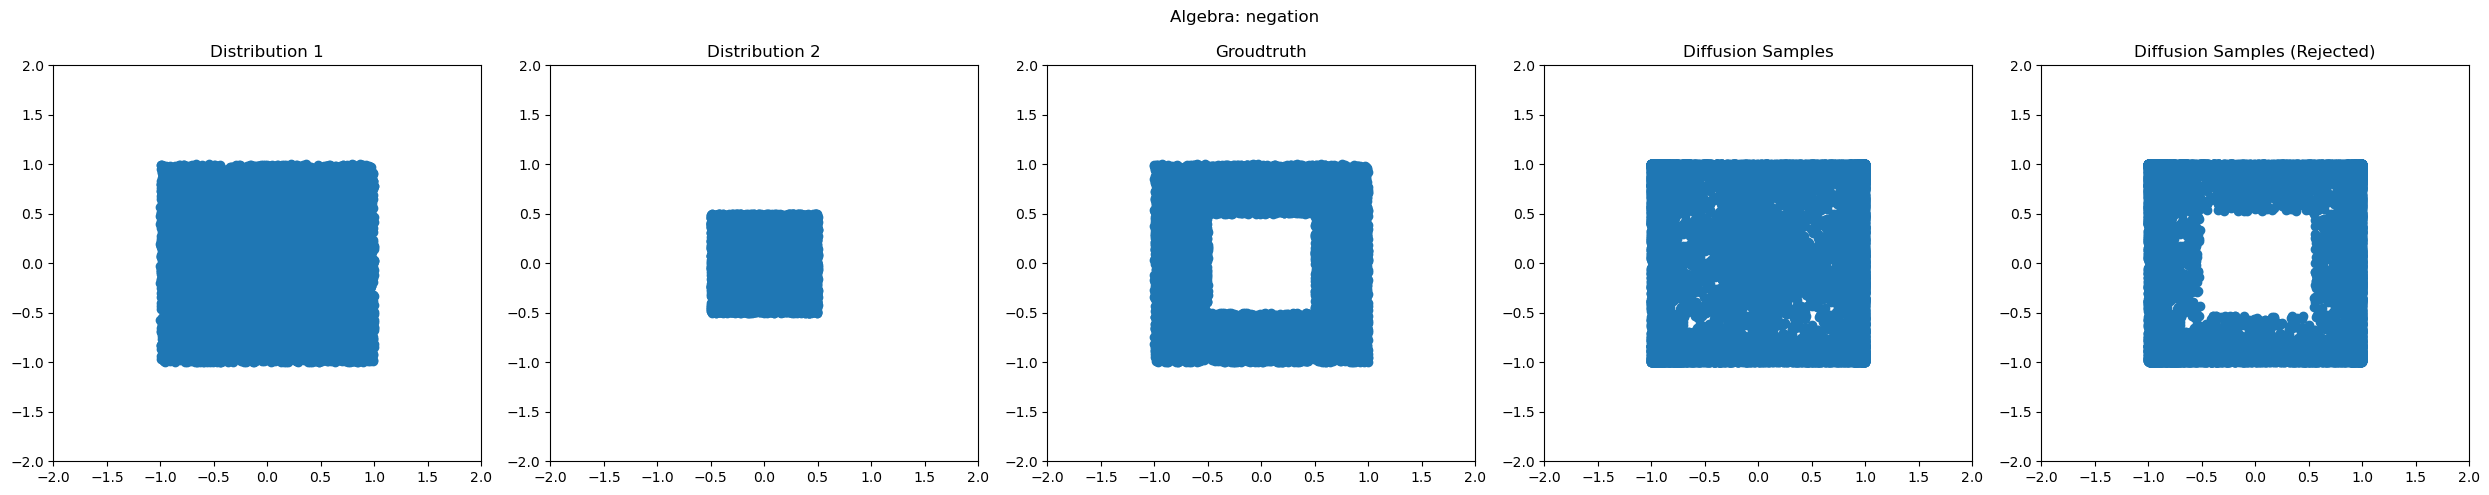

negation_a3, original Wasserstein-2 distance: 0.03782791539132602, filtered Wasserstein-2 distance: 0.04867832662830426, sample ratio: 0.8917


100%|██████████| 50/50 [00:00<00:00, 198.93it/s]


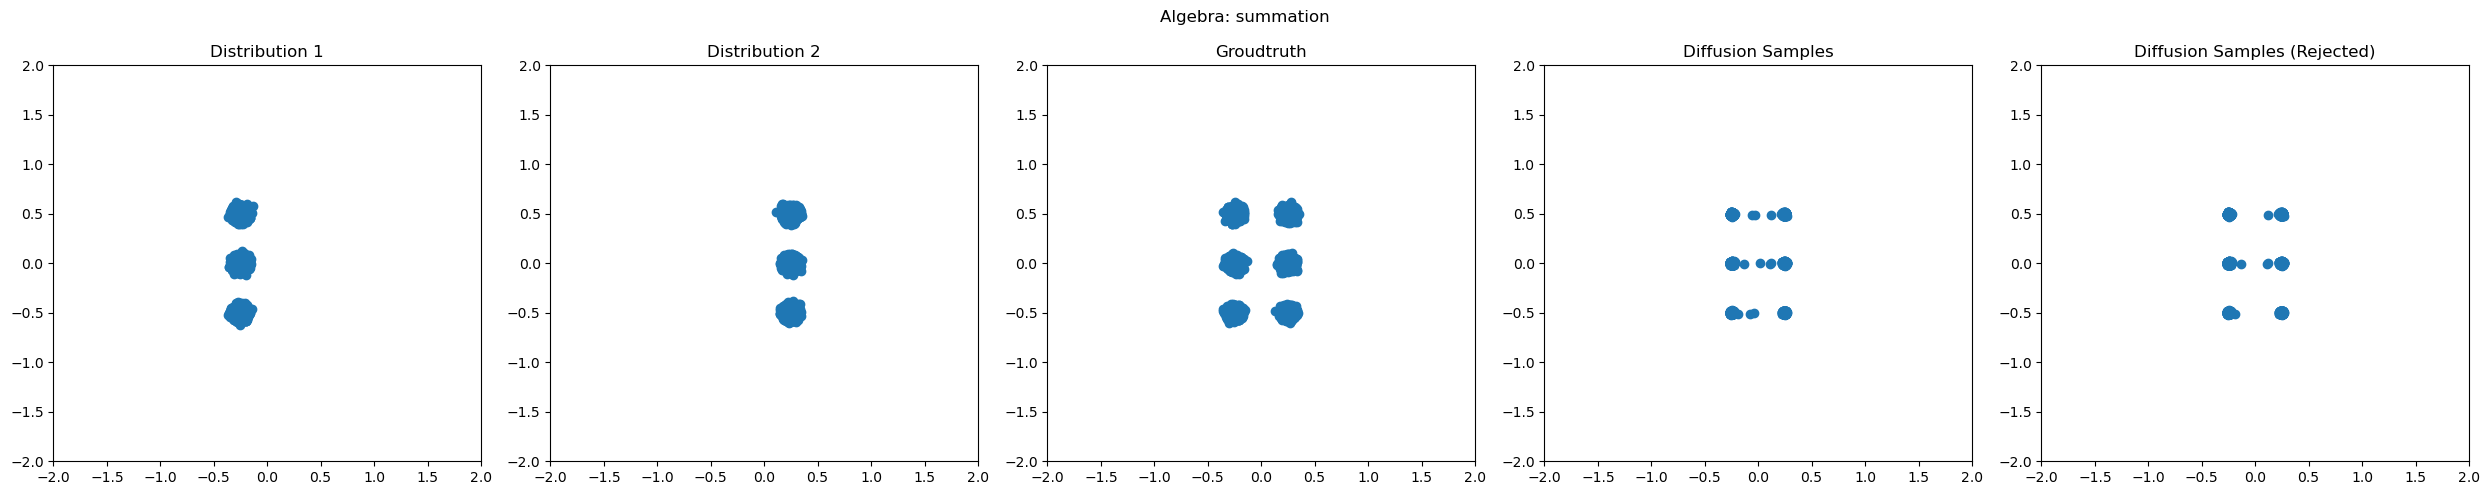

summation_a3, original Wasserstein-2 distance: 0.047537148598318, filtered Wasserstein-2 distance: 0.047596051464302847, sample ratio: 0.9995


100%|██████████| 50/50 [00:00<00:00, 203.43it/s]


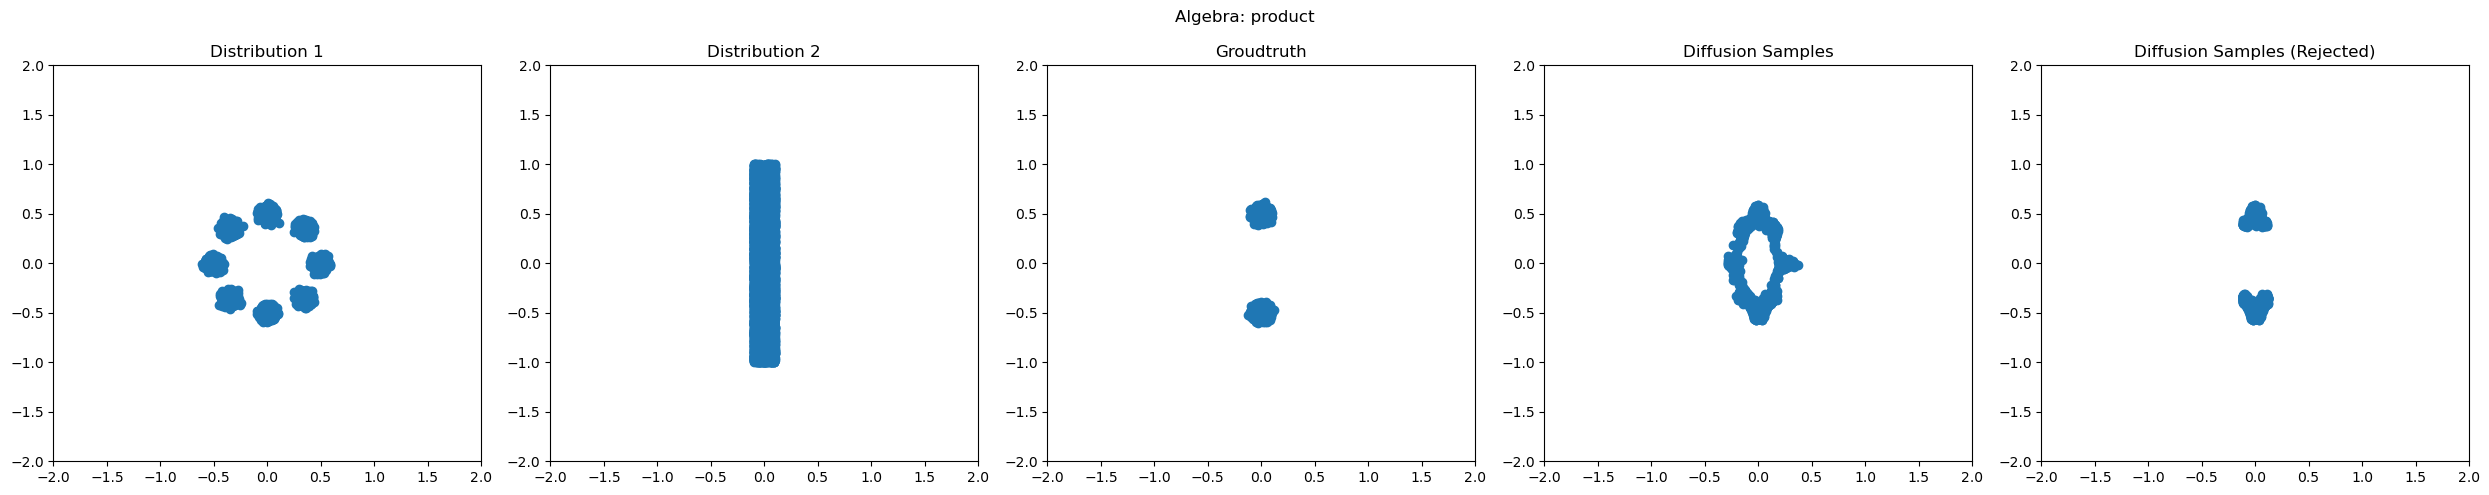

product_a3, original Wasserstein-2 distance: 0.011153426764160364, filtered Wasserstein-2 distance: 0.025360235640729194, sample ratio: 0.8534


In [37]:
# compare EBM with normal diffusion

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, evaluate_W2
from bootstrapping import bootstrapping_and_get_max
from datasets import generate_data_points
from r_and_r import calculate_interval_multiple_timesteps, calculate_interval


def calculate_threshold(samples, model, confidence=0.999):
    # calculate the level-set values
    with torch.no_grad():
        energy_on_data = model.energy(torch.from_numpy(samples).cuda(), torch.zeros(len(samples)).long().cuda())
    extreme_value = bootstrapping_and_get_max(energy_on_data.cpu().numpy(), confidence=confidence)
    return extreme_value

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()

method_fn = diffusion_baseline
eval_batch_size = 10000
for algebra in ['negation', 'summation', 'product']:
    environment = algebra + '_' + 'a3'
    model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
    model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
    model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
    generated_samples = method_fn(model_to_test, eval_batch_size=eval_batch_size)[-1]

    dataset_1 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a1')
    dataset_2 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a2')
    dataset_3 = generate_data_points(n=eval_batch_size, dataset=environment)
    interval_1_l, interval_1_r = calculate_interval(dataset_1, model_1)
    interval_2_l, interval_2_r = calculate_interval(dataset_2, model_2)

    # evaluate generated_samples on energy
    Z1 = model_1.energy(torch.from_numpy(generated_samples).cuda().float(), torch.zeros(len(generated_samples)).long().cuda()).detach().cpu().numpy()
    Z2 = model_2.energy(torch.from_numpy(generated_samples).cuda().float(), torch.zeros(len(generated_samples)).long().cuda()).detach().cpu().numpy()
    if algebra == 'product':
        new_generated_samples = generated_samples[(Z1 < interval_1_r) & (Z2 < interval_2_r)]
    elif algebra == 'summation':
        new_generated_samples = generated_samples[(Z1 < interval_1_r) | (Z2 < interval_2_r)]
    elif algebra == 'negation':
        new_generated_samples = generated_samples[(Z1 < interval_1_r) & (Z2 > interval_2_r)]
    
    previous_w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset_3)
    new_w2_distance = evaluate_W2(generated_samples=new_generated_samples, target_samples=dataset_3)

    plt.close('all')
    
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    i = 0
    axes[i].scatter(*dataset_1.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Distribution 1')

    i += 1
    axes[i].scatter(*dataset_2.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Distribution 2')

    i += 1
    axes[i].scatter(*dataset_3.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Groudtruth')    

    i += 1
    axes[i].scatter(*generated_samples.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Diffusion Samples')

    i += 1
    axes[i].scatter(*new_generated_samples.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Diffusion Samples (Rejected)')
    
    fig.suptitle(f'Algebra: {algebra}')
    
    plt.tight_layout()
    plt.savefig(f'figures/filtering_diffusion_last_t_{algebra}')
    plt.show()
    
    print(f"{environment}, original Wasserstein-2 distance: {previous_w2_distance}, filtered Wasserstein-2 distance: {new_w2_distance}, sample ratio: {len(new_generated_samples)/len(generated_samples)}")

# W2 distance for energy piece through all timestep (for composed energy values, extreme values computed through data from joint distribution)

100%|██████████| 50/50 [00:00<00:00, 137.33it/s]


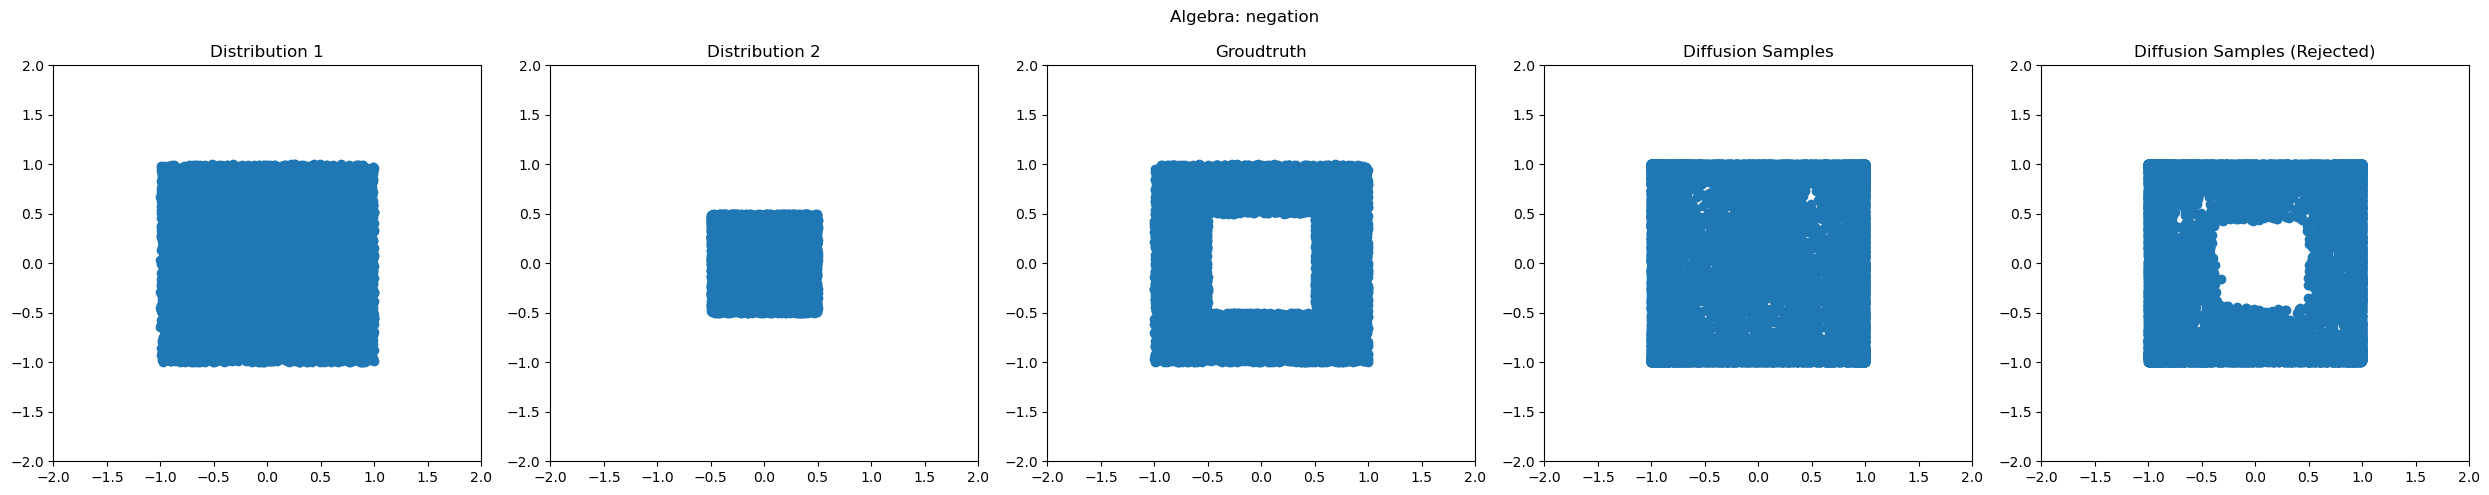

negation_a3, original Wasserstein-2 distance: 0.035630610224604634, filtered Wasserstein-2 distance: 0.04014594637453546, sample ratio: 1.0


100%|██████████| 50/50 [00:00<00:00, 138.30it/s]


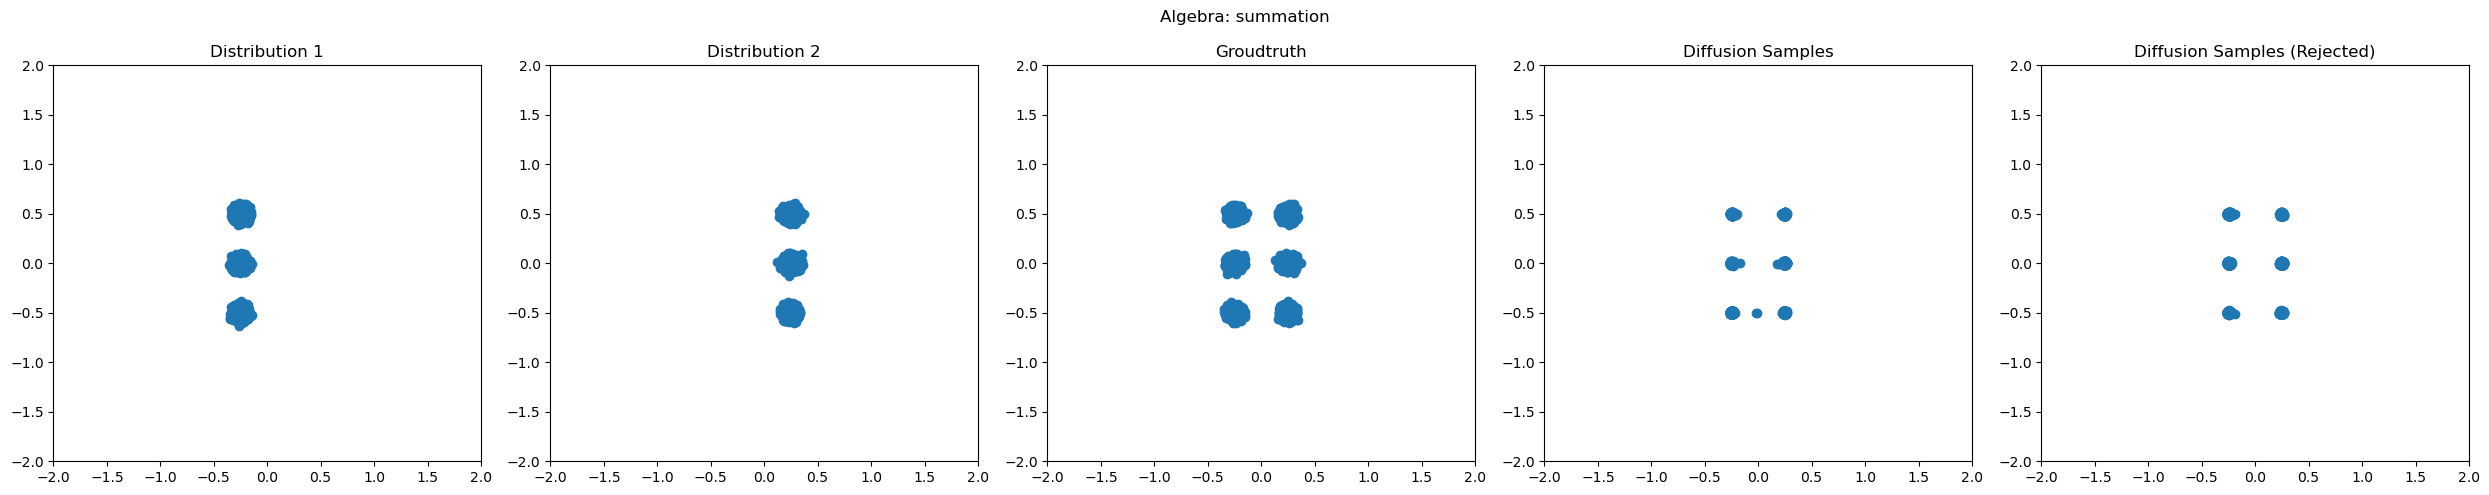

summation_a3, original Wasserstein-2 distance: 0.04683602310632861, filtered Wasserstein-2 distance: 0.04781495336017654, sample ratio: 1.0


100%|██████████| 50/50 [00:00<00:00, 139.04it/s]


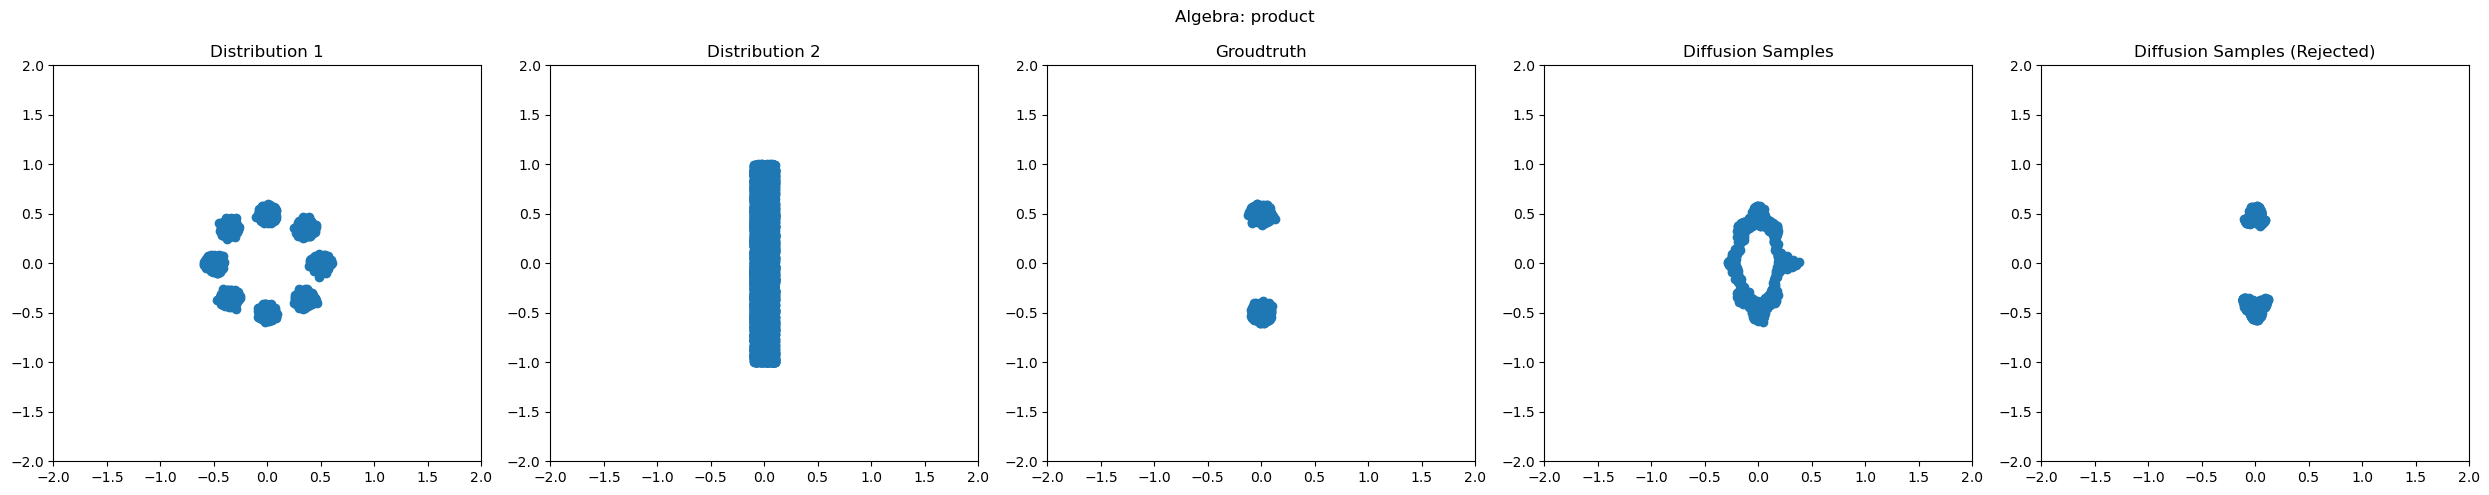

product_a3, original Wasserstein-2 distance: 0.009626022453606093, filtered Wasserstein-2 distance: 0.02169505428522821, sample ratio: 1.0


In [40]:
# compare EBM with normal diffusion

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, diffusion_rejection_baseline, evaluate_W2
from bootstrapping import bootstrapping_and_get_max
from datasets import generate_data_points
from r_and_r import calculate_interval_multiple_timesteps, calculate_interval


def calculate_threshold(samples, model, confidence=0.999):
    # calculate the level-set values
    with torch.no_grad():
        energy_on_data = model.energy(torch.from_numpy(samples).cuda(), torch.zeros(len(samples)).long().cuda())
    extreme_value = bootstrapping_and_get_max(energy_on_data.cpu().numpy(), confidence=confidence)
    return extreme_value

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()

eval_batch_size = 10000
for algebra in ['negation', 'summation', 'product']:
    environment = algebra + '_' + 'a3'
    model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
    model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
    model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
    generated_samples = diffusion_baseline(model_to_test, eval_batch_size=eval_batch_size)[-1]

    dataset_1 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a1')
    dataset_2 = generate_data_points(n=eval_batch_size, dataset=algebra + '_' + 'a2')
    dataset_3 = generate_data_points(n=eval_batch_size, dataset=environment)

    intervals_1 = calculate_interval_multiple_timesteps(samples=dataset_1, model=model_1)
    if algebra=='negation':
        intervals_2 = calculate_interval_to_avoid_multiple_timesteps(samples_to_reach=dataset_3, samples_to_avoid=dataset_2, model=model_2)
    else:
        intervals_2 = calculate_interval_multiple_timesteps(samples=dataset_2, model=model_2)

    new_generated_samples, filter_ratios = diffusion_rejection_baseline(composed_model=model_to_test,
                                               models=[model_1, model_2],
                                               algebra=algebra,
                                               intervals=[intervals_1, intervals_2],
                                               eval_batch_size=eval_batch_size)
    new_generated_samples = new_generated_samples[-1]        
    
    previous_w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset_3)
    new_w2_distance = evaluate_W2(generated_samples=new_generated_samples, target_samples=dataset_3)

    plt.close('all')
    
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    i = 0
    axes[i].scatter(*dataset_1.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Distribution 1')

    i += 1
    axes[i].scatter(*dataset_2.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Distribution 2')

    i += 1
    axes[i].scatter(*dataset_3.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Groudtruth')    

    i += 1
    axes[i].scatter(*generated_samples.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Diffusion Samples')

    i += 1
    axes[i].scatter(*new_generated_samples.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Diffusion Samples (Rejected)')
    
    fig.suptitle(f'Algebra: {algebra}')
    
    plt.tight_layout()
    plt.savefig(f'figures/filtering_diffusion_multiple_t_{algebra}')
    plt.show()
    
    print(f"{environment}, original Wasserstein-2 distance: {previous_w2_distance}, filtered Wasserstein-2 distance: {new_w2_distance}, sample ratio: {len(new_generated_samples)/len(generated_samples)}")

# W2 distance for energy piece through all timestep (for composed energy values, extreme values computed through data from diffusion data)

100%|██████████| 50/50 [00:00<00:00, 135.60it/s]


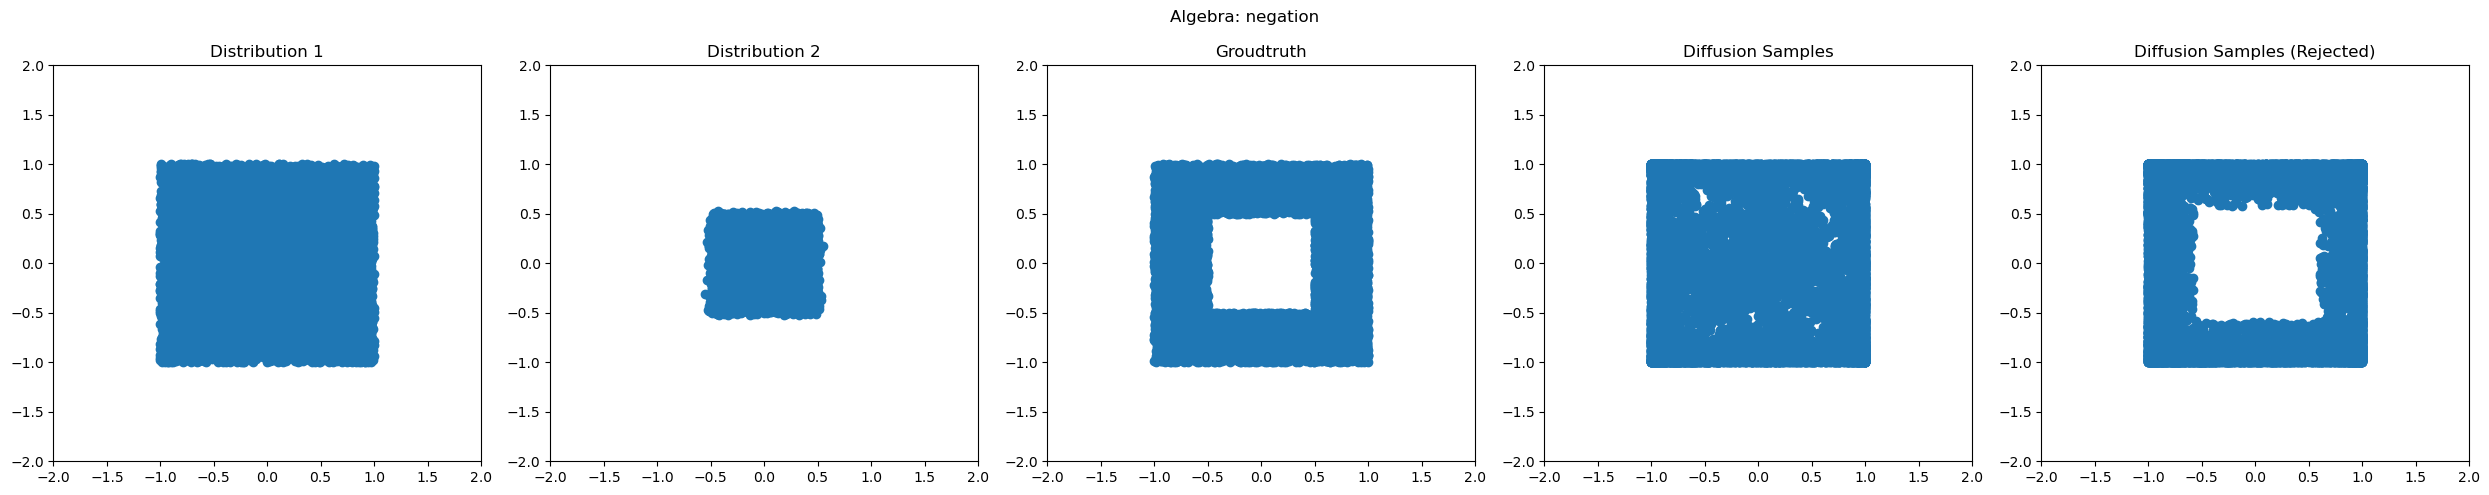

negation_a3, original Wasserstein-2 distance: 0.035253442753851505, filtered Wasserstein-2 distance: 0.05001398794054995, sample ratio: 1.0


100%|██████████| 50/50 [00:00<00:00, 136.09it/s]


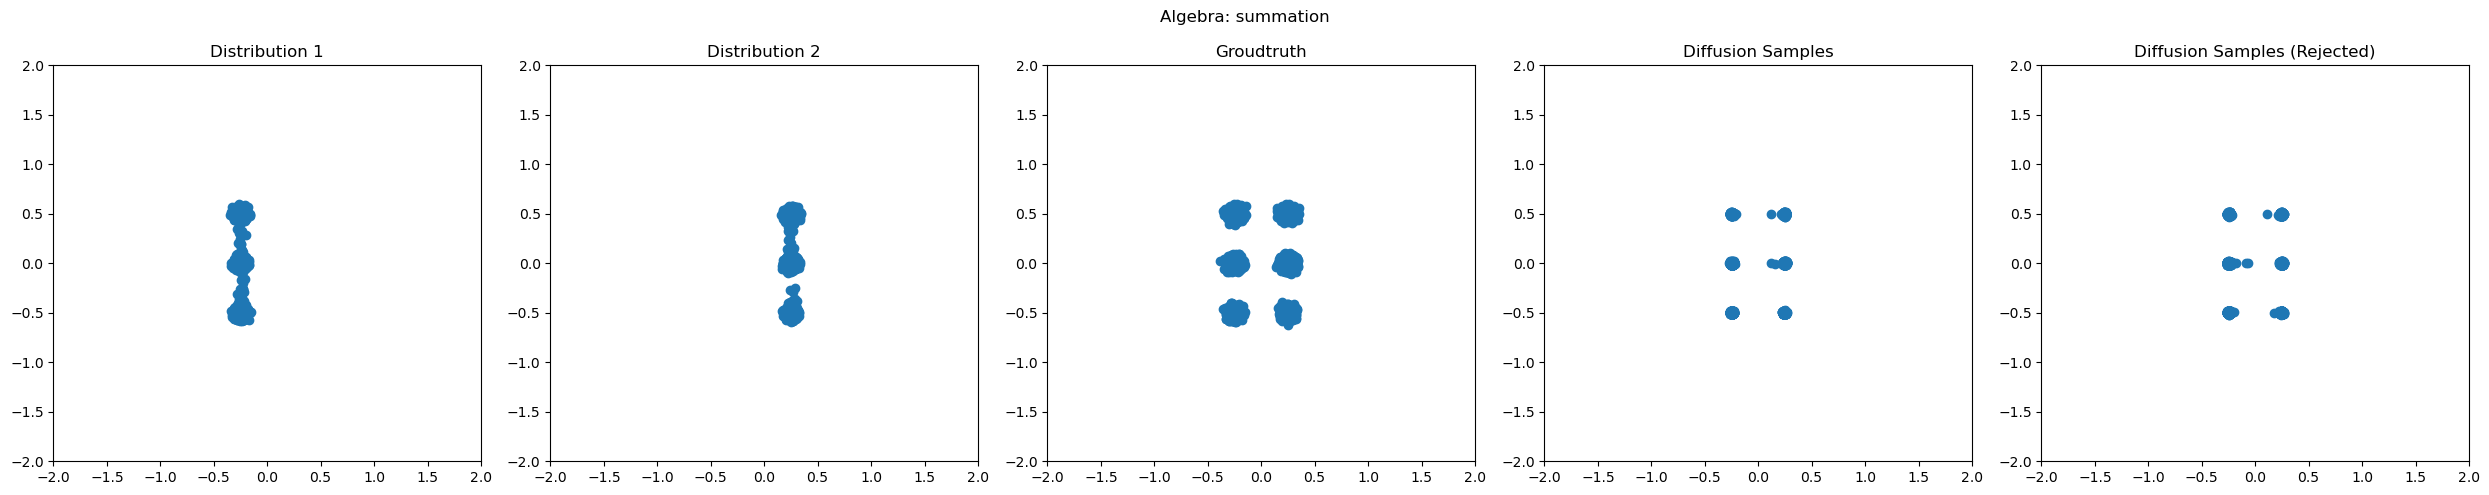

summation_a3, original Wasserstein-2 distance: 0.04836723152231813, filtered Wasserstein-2 distance: 0.04891244932101647, sample ratio: 1.0


100%|██████████| 50/50 [00:00<00:00, 136.78it/s]


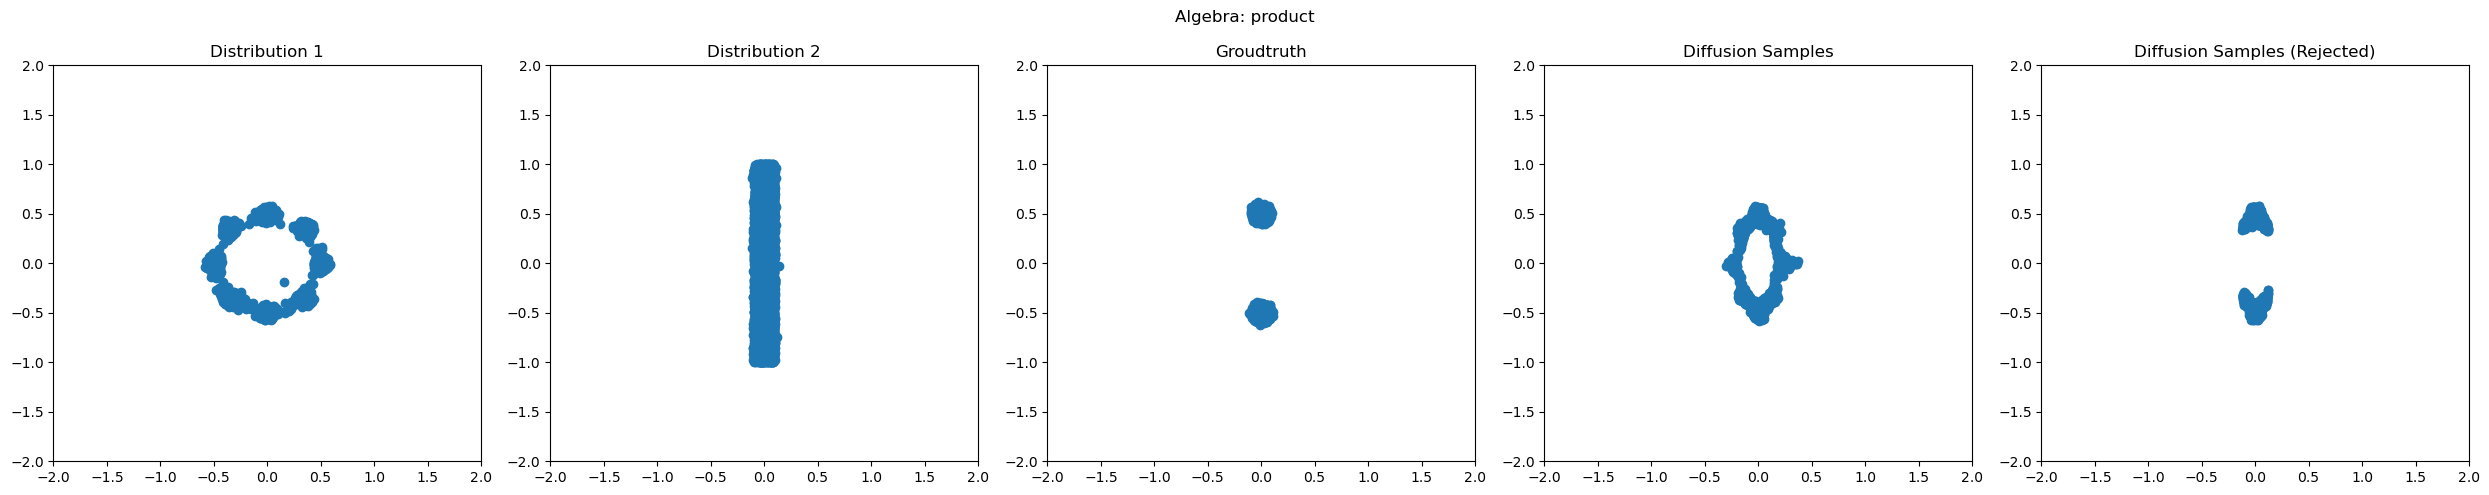

product_a3, original Wasserstein-2 distance: 0.009500945992022765, filtered Wasserstein-2 distance: 0.021349656839668708, sample ratio: 1.0


In [48]:
# compare EBM with normal diffusion

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, diffusion_rejection_baseline, evaluate_W2
from bootstrapping import bootstrapping_and_get_max
from datasets import generate_data_points
from r_and_r import calculate_interval_multiple_timesteps, calculate_interval, calculate_energy, need_to_remove_with_thresholds

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()

eval_batch_size = 10000
for algebra in ['negation', 'summation', 'product']:
    environment = algebra + '_' + 'a3'
    model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
    model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
    model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
    generated_samples = diffusion_baseline(model_to_test, eval_batch_size=eval_batch_size)[-1]

    dataset_1 = diffusion_baseline(model_1, eval_batch_size=eval_batch_size)[-1]
    dataset_2 = diffusion_baseline(model_2, eval_batch_size=eval_batch_size)[-1]
    dataset_3_origin = diffusion_baseline(model_to_test, eval_batch_size=eval_batch_size)[-1]
    interval_1 = calculate_interval(samples=dataset_1, model=model_1)
    interval_2 = calculate_interval(samples=dataset_2, model=model_2)
    energy_1 = calculate_energy(samples=dataset_3_origin, model=model_1)
    energy_2 = calculate_energy(samples=dataset_3_origin, model=model_2)
    need_to_remove = need_to_remove_with_thresholds(algebra=algebra, 
                                                    energy_1=energy_1, energy_2=energy_2,
                                                    interval_1=interval_1, interval_2=interval_2)
    dataset_3 = dataset_3_origin[~need_to_remove]

    intervals_1 = calculate_interval_multiple_timesteps(samples=dataset_1, model=model_1)
    if algebra=='negation':
        intervals_2 = calculate_interval_to_avoid_multiple_timesteps(samples_to_reach=dataset_3, samples_to_avoid=dataset_2, model=model_2)
    else:
        intervals_2 = calculate_interval_multiple_timesteps(samples=dataset_2, model=model_2)

    new_generated_samples, filter_ratios = diffusion_rejection_baseline(composed_model=model_to_test,
                                               models=[model_1, model_2],
                                               algebra=algebra,
                                               intervals=[intervals_1, intervals_2],
                                               eval_batch_size=eval_batch_size)
    new_generated_samples = new_generated_samples[-1]        

    dataset_3 = generate_data_points(n=eval_batch_size, dataset=environment)
    previous_w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset_3)
    new_w2_distance = evaluate_W2(generated_samples=new_generated_samples, target_samples=dataset_3)

    plt.close('all')
    
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    i = 0
    axes[i].scatter(*dataset_1.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Distribution 1')

    i += 1
    axes[i].scatter(*dataset_2.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Distribution 2')

    i += 1
    axes[i].scatter(*dataset_3.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Groudtruth')    

    i += 1
    axes[i].scatter(*generated_samples.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Diffusion Samples')

    i += 1
    axes[i].scatter(*new_generated_samples.T)
    axes[i].set_xlim(-2, 2)
    axes[i].set_ylim(-2, 2)
    axes[i].set_title('Diffusion Samples (Rejected)')
    
    fig.suptitle(f'Algebra: {algebra}')
    
    plt.tight_layout()
    plt.savefig(f'figures/filtering_diffusion_multiple_t_{algebra}')
    plt.show()
    
    print(f"{environment}, original Wasserstein-2 distance: {previous_w2_distance}, filtered Wasserstein-2 distance: {new_w2_distance}, sample ratio: {len(new_generated_samples)/len(generated_samples)}")

# More Dataset

In [ ]:
# compare EBM with normal diffusion

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, diffusion_rejection_baseline, evaluate_W2
from bootstrapping import bootstrapping_and_get_max
from datasets import generate_data_points
from r_and_r import calculate_interval_multiple_timesteps, calculate_interval, calculate_energy, need_to_remove_with_thresholds

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()

eval_batch_size = 10000
for algebra in ['product']:  # 'negation', 'summation',
    for suffix in ['a', 'b', 'c']:
        environment = f'{algebra}_{suffix}3'
        model_1.load_state_dict(torch.load(f"exps/{algebra}_{suffix}1/ema_model.pth"))
        model_2.load_state_dict(torch.load(f"exps/{algebra}_{suffix}2/ema_model.pth"))
        model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
        generated_samples = diffusion_baseline(model_to_test, eval_batch_size=eval_batch_size)[-1]
    
        dataset_1 = diffusion_baseline(model_1, eval_batch_size=eval_batch_size)[-1]
        dataset_2 = diffusion_baseline(model_2, eval_batch_size=eval_batch_size)[-1]
        dataset_3_origin = diffusion_baseline(model_to_test, eval_batch_size=eval_batch_size)[-1]
        interval_1 = calculate_interval(samples=dataset_1, model=model_1)
        interval_2 = calculate_interval(samples=dataset_2, model=model_2)
        energy_1 = calculate_energy(samples=dataset_3_origin, model=model_1)
        energy_2 = calculate_energy(samples=dataset_3_origin, model=model_2)
        need_to_remove = need_to_remove_with_thresholds(algebra=algebra, 
                                                        energy_1=energy_1, energy_2=energy_2,
                                                        interval_1=interval_1, interval_2=interval_2)
        dataset_3 = dataset_3_origin[~need_to_remove]
        print(environment, 'len of dataset_3', len(dataset_3))
    
        intervals_1 = calculate_interval_multiple_timesteps(samples=dataset_1, model=model_1)
        if algebra=='negation':
            intervals_2 = calculate_interval_to_avoid_multiple_timesteps(samples_to_reach=dataset_3, samples_to_avoid=dataset_2, model=model_2)
        else:
            intervals_2 = calculate_interval_multiple_timesteps(samples=dataset_2, model=model_2)
    
        new_generated_samples, filter_ratios = diffusion_rejection_baseline(composed_model=model_to_test,
                                                   models=[model_1, model_2],
                                                   algebra=algebra,
                                                   intervals=[intervals_1, intervals_2],
                                                   eval_batch_size=eval_batch_size)
        new_generated_samples = new_generated_samples[-1]        
    
        # dataset_3 = generate_data_points(n=eval_batch_size, dataset=environment)
        # previous_w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset_3)
        # new_w2_distance = evaluate_W2(generated_samples=new_generated_samples, target_samples=dataset_3)
        # print(f"{environment}, original Wasserstein-2 distance: {previous_w2_distance}, filtered Wasserstein-2 distance: {new_w2_distance}, sample ratio: {len(new_generated_samples)/len(generated_samples)}")
    
        plt.close('all')
        
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    
        i = 0
        dataset_1 = generate_data_points(n=eval_batch_size, dataset=f'{algebra}_{suffix}1')
        axes[i].scatter(*dataset_1.T)
        axes[i].set_xlim(-2, 2)
        axes[i].set_ylim(-2, 2)
        axes[i].set_title('Distribution 1')
    
        i += 1
        dataset_2 = generate_data_points(n=eval_batch_size, dataset=f'{algebra}_{suffix}2')
        axes[i].scatter(*dataset_2.T)
        axes[i].set_xlim(-2, 2)
        axes[i].set_ylim(-2, 2)
        axes[i].set_title('Distribution 2')
    
        i += 1
        dataset_3 = generate_data_points(n=eval_batch_size, dataset=environment)
        axes[i].scatter(*dataset_3.T)
        axes[i].set_xlim(-2, 2)
        axes[i].set_ylim(-2, 2)
        axes[i].set_title('Groudtruth')    
    
        i += 1
        axes[i].scatter(*generated_samples.T)
        axes[i].set_xlim(-2, 2)
        axes[i].set_ylim(-2, 2)
        axes[i].set_title('Diffusion Samples')
    
        i += 1
        axes[i].scatter(*new_generated_samples.T)
        axes[i].set_xlim(-2, 2)
        axes[i].set_ylim(-2, 2)
        axes[i].set_title('Diffusion Samples (Rejected)')
        
        fig.suptitle(f'Algebra: {algebra}')
        
        plt.tight_layout()
        plt.savefig(f'figures/filtering_diffusion_multiple_t_{algebra}_{suffix}')
        plt.show()

100%|██████████| 50/50 [00:00<00:00, 205.52it/s]


product_a3 len of dataset_3 8657


In [92]:
from utils import merge_pic
for algebra in ['product', 'summation', 'negation']:
    image_paths = [f'figures/filtering_diffusion_multiple_t_{algebra}_{suffix}.png' for suffix in ['a', 'b', 'c']]
    merge_pic(image_paths, 1, len(image_paths), f'figures/filtering_diffusion_multiple_t_{algebra}.png')

# TBD: Multiple Algebra Composition

# TBD: Guided Sampling (using Gradient) based on Energy Value through Multiple Timestep (TBD)

# Benchmark Baselines

In [5]:
# compare EBM across different temperatures

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, evaluate_W2
from datasets import generate_data_points
from IPython import embed

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()
method = 'ebm'
for temperature in [0.1, 0.3, 0.6, 1.0]:
    method_fn = ebm_baseline
    for algebra in ['product', 'summation', 'negation']:
        for suffix in ['a1', 'a2', 'a3']:
            environment = algebra + '_' + suffix
            if suffix != 'a3':
                model_1.load_state_dict(torch.load(f"exps/{environment}/ema_model.pth"))
                model_to_test = model_1
            else:
                model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
                model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
                model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
            generated_samples = method_fn(model_to_test, temperature=temperature)[-1]
            dataset = generate_data_points(n=8000, dataset=environment)
            w2_distance = evaluate_W2(generated_samples=generated_samples, target_samples=dataset)
            
            print(f"{method} with temperature {temperature} for {environment}, Wasserstein-2 distance:", w2_distance)

100%|██████████| 500/500 [00:06<00:00, 75.37it/s]


ebm with temperature 0.1 for product_a1, Wasserstein-2 distance: 0.11268077258486289


100%|██████████| 500/500 [00:06<00:00, 75.36it/s]


ebm with temperature 0.1 for product_a2, Wasserstein-2 distance: 0.3200648770383273


100%|██████████| 500/500 [00:12<00:00, 38.55it/s]


ebm with temperature 0.1 for product_a3, Wasserstein-2 distance: 0.0223134100958705


100%|██████████| 500/500 [00:06<00:00, 75.57it/s]


ebm with temperature 0.1 for summation_a1, Wasserstein-2 distance: 0.0103084189773779


100%|██████████| 500/500 [00:06<00:00, 75.53it/s]


ebm with temperature 0.1 for summation_a2, Wasserstein-2 distance: 0.019964581381430306


100%|██████████| 500/500 [00:13<00:00, 38.15it/s]


ebm with temperature 0.1 for summation_a3, Wasserstein-2 distance: 0.004264864354856886


100%|██████████| 500/500 [00:06<00:00, 75.44it/s]


ebm with temperature 0.1 for negation_a1, Wasserstein-2 distance: 0.9292871270875338


100%|██████████| 500/500 [00:06<00:00, 75.37it/s]


ebm with temperature 0.1 for negation_a2, Wasserstein-2 distance: 0.008761829923533677


100%|██████████| 500/500 [00:13<00:00, 38.13it/s]


ebm with temperature 0.1 for negation_a3, Wasserstein-2 distance: 10.418198533389672


100%|██████████| 500/500 [00:06<00:00, 75.34it/s]


ebm with temperature 0.3 for product_a1, Wasserstein-2 distance: 0.0182457393975928


100%|██████████| 500/500 [00:06<00:00, 75.21it/s]


ebm with temperature 0.3 for product_a2, Wasserstein-2 distance: 0.0006308835276659039


100%|██████████| 500/500 [00:13<00:00, 38.44it/s]


ebm with temperature 0.3 for product_a3, Wasserstein-2 distance: 0.022398112621158338


100%|██████████| 500/500 [00:06<00:00, 75.31it/s]


ebm with temperature 0.3 for summation_a1, Wasserstein-2 distance: 0.002199786112091139


100%|██████████| 500/500 [00:06<00:00, 75.31it/s]


ebm with temperature 0.3 for summation_a2, Wasserstein-2 distance: 0.0018153719417750636


100%|██████████| 500/500 [00:13<00:00, 38.13it/s]


ebm with temperature 0.3 for summation_a3, Wasserstein-2 distance: 0.0012952515311265137


100%|██████████| 500/500 [00:06<00:00, 75.11it/s]


ebm with temperature 0.3 for negation_a1, Wasserstein-2 distance: 0.022319999599967544


100%|██████████| 500/500 [00:06<00:00, 75.45it/s]


ebm with temperature 0.3 for negation_a2, Wasserstein-2 distance: 0.0014005688891738821


100%|██████████| 500/500 [00:13<00:00, 38.10it/s]


ebm with temperature 0.3 for negation_a3, Wasserstein-2 distance: 2.3352857966870055


100%|██████████| 500/500 [00:06<00:00, 75.50it/s]


ebm with temperature 0.6 for product_a1, Wasserstein-2 distance: 0.018797367892228026


100%|██████████| 500/500 [00:06<00:00, 75.32it/s]


ebm with temperature 0.6 for product_a2, Wasserstein-2 distance: 0.0006921439305060635


100%|██████████| 500/500 [00:12<00:00, 38.53it/s]


ebm with temperature 0.6 for product_a3, Wasserstein-2 distance: 0.020624794440343968


100%|██████████| 500/500 [00:06<00:00, 75.13it/s]


ebm with temperature 0.6 for summation_a1, Wasserstein-2 distance: 0.0007137611140350342


100%|██████████| 500/500 [00:06<00:00, 75.24it/s]


ebm with temperature 0.6 for summation_a2, Wasserstein-2 distance: 0.0011315681689007314


100%|██████████| 500/500 [00:13<00:00, 38.20it/s]


ebm with temperature 0.6 for summation_a3, Wasserstein-2 distance: 0.0022553536893163595


100%|██████████| 500/500 [00:06<00:00, 75.14it/s]


ebm with temperature 0.6 for negation_a1, Wasserstein-2 distance: 0.0038780102732343886


100%|██████████| 500/500 [00:06<00:00, 75.01it/s]


ebm with temperature 0.6 for negation_a2, Wasserstein-2 distance: 0.001855902103365227


100%|██████████| 500/500 [00:13<00:00, 38.11it/s]


ebm with temperature 0.6 for negation_a3, Wasserstein-2 distance: 0.19564728756807717


100%|██████████| 500/500 [00:06<00:00, 75.08it/s]


ebm with temperature 1.0 for product_a1, Wasserstein-2 distance: 0.02230413443036375


100%|██████████| 500/500 [00:06<00:00, 75.13it/s]


ebm with temperature 1.0 for product_a2, Wasserstein-2 distance: 0.0011505292222102584


100%|██████████| 500/500 [00:13<00:00, 38.37it/s]


ebm with temperature 1.0 for product_a3, Wasserstein-2 distance: 0.020433615304529765


100%|██████████| 500/500 [00:06<00:00, 74.94it/s]


ebm with temperature 1.0 for summation_a1, Wasserstein-2 distance: 0.0010589249713011165


100%|██████████| 500/500 [00:06<00:00, 75.11it/s]


ebm with temperature 1.0 for summation_a2, Wasserstein-2 distance: 0.0012980454853385975


100%|██████████| 500/500 [00:13<00:00, 37.89it/s]


ebm with temperature 1.0 for summation_a3, Wasserstein-2 distance: 0.0036244865163508563


100%|██████████| 500/500 [00:06<00:00, 74.96it/s]


ebm with temperature 1.0 for negation_a1, Wasserstein-2 distance: 0.007581588738525165


100%|██████████| 500/500 [00:06<00:00, 74.95it/s]


ebm with temperature 1.0 for negation_a2, Wasserstein-2 distance: 0.003051268544892087


100%|██████████| 500/500 [00:13<00:00, 38.11it/s]


ebm with temperature 1.0 for negation_a3, Wasserstein-2 distance: 0.24904078618064568


In [13]:
# compare EBM across different timesteps

import ddpm
import torch
from baselines import ebm_baseline, diffusion_baseline, evaluate_W2, intermediate_distribution
from datasets import generate_data_points
from IPython import embed

model_1 = ddpm.EnergyMLP()
model_2 = ddpm.EnergyMLP()
method = 'ebm'
method_fn = ebm_baseline
for algebra in ['product', 'summation', 'negation']:
    for suffix in ['a1', 'a2', 'a3']:
        environment = algebra + '_' + suffix
        if suffix != 'a3':
            model_1.load_state_dict(torch.load(f"exps/{environment}/ema_model.pth"))
            model_to_test = model_1
        else:
            model_1.load_state_dict(torch.load(f"exps/{algebra}_a1/ema_model.pth"))
            model_2.load_state_dict(torch.load(f"exps/{algebra}_a2/ema_model.pth"))
            model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra=algebra)
        generated_samples = method_fn(model_to_test)
        dataset = generate_data_points(n=8000, dataset=environment)
        intermediate_samples = intermediate_distribution(data_points=dataset)[1:]
        for i, sample_pair in enumerate(zip(generated_samples, intermediate_samples)):
            w2_distance = evaluate_W2(generated_samples=sample_pair[0], target_samples=sample_pair[1])
            print(f"{method} for {environment}, timestep {i}, Wasserstein-2 distance:", w2_distance)

100%|██████████| 490/490 [00:06<00:00, 77.20it/s]


ebm for product_a1, timestep 0, Wasserstein-2 distance: 0.9191499506123579
ebm for product_a1, timestep 1, Wasserstein-2 distance: 0.09240718123772969
ebm for product_a1, timestep 2, Wasserstein-2 distance: 0.045173872988809406
ebm for product_a1, timestep 3, Wasserstein-2 distance: 0.018844791758721845
ebm for product_a1, timestep 4, Wasserstein-2 distance: 0.010350727568937141
ebm for product_a1, timestep 5, Wasserstein-2 distance: 0.006767264231028103
ebm for product_a1, timestep 6, Wasserstein-2 distance: 0.00479715479958031
ebm for product_a1, timestep 7, Wasserstein-2 distance: 0.004392151477582045
ebm for product_a1, timestep 8, Wasserstein-2 distance: 0.003704005611989476
ebm for product_a1, timestep 9, Wasserstein-2 distance: 0.003503894507699446
ebm for product_a1, timestep 10, Wasserstein-2 distance: 0.0034579133046147514
ebm for product_a1, timestep 11, Wasserstein-2 distance: 0.003243050338366636
ebm for product_a1, timestep 12, Wasserstein-2 distance: 0.002638505711340274

100%|██████████| 490/490 [00:06<00:00, 77.17it/s]


ebm for product_a2, timestep 0, Wasserstein-2 distance: 0.9882956106117194
ebm for product_a2, timestep 1, Wasserstein-2 distance: 0.09172900891141969
ebm for product_a2, timestep 2, Wasserstein-2 distance: 0.03586753208830485
ebm for product_a2, timestep 3, Wasserstein-2 distance: 0.0157176120896693
ebm for product_a2, timestep 4, Wasserstein-2 distance: 0.007260675403849757
ebm for product_a2, timestep 5, Wasserstein-2 distance: 0.005273082016756228
ebm for product_a2, timestep 6, Wasserstein-2 distance: 0.004606647750693823
ebm for product_a2, timestep 7, Wasserstein-2 distance: 0.0038817321901115135
ebm for product_a2, timestep 8, Wasserstein-2 distance: 0.003365025258968667
ebm for product_a2, timestep 9, Wasserstein-2 distance: 0.004820783198541901
ebm for product_a2, timestep 10, Wasserstein-2 distance: 0.0034009923518160574
ebm for product_a2, timestep 11, Wasserstein-2 distance: 0.0030475802227592627
ebm for product_a2, timestep 12, Wasserstein-2 distance: 0.002859775943256191

100%|██████████| 490/490 [00:12<00:00, 39.04it/s]


ebm for product_a3, timestep 0, Wasserstein-2 distance: 0.9459488868028189
ebm for product_a3, timestep 1, Wasserstein-2 distance: 0.008266283679128735
ebm for product_a3, timestep 2, Wasserstein-2 distance: 0.02016737066372667
ebm for product_a3, timestep 3, Wasserstein-2 distance: 0.04869766387620963
ebm for product_a3, timestep 4, Wasserstein-2 distance: 0.05812730915383511
ebm for product_a3, timestep 5, Wasserstein-2 distance: 0.054626231810987545
ebm for product_a3, timestep 6, Wasserstein-2 distance: 0.05339653241027559
ebm for product_a3, timestep 7, Wasserstein-2 distance: 0.05603877202276263
ebm for product_a3, timestep 8, Wasserstein-2 distance: 0.0613606976193879
ebm for product_a3, timestep 9, Wasserstein-2 distance: 0.05470422507337904
ebm for product_a3, timestep 10, Wasserstein-2 distance: 0.05201131373029508
ebm for product_a3, timestep 11, Wasserstein-2 distance: 0.054502471893123856
ebm for product_a3, timestep 12, Wasserstein-2 distance: 0.046664540847726414
ebm for

100%|██████████| 490/490 [00:06<00:00, 77.16it/s]


ebm for summation_a1, timestep 0, Wasserstein-2 distance: 0.9050126021664144
ebm for summation_a1, timestep 1, Wasserstein-2 distance: 0.12891958172761422
ebm for summation_a1, timestep 2, Wasserstein-2 distance: 0.05197933726758445
ebm for summation_a1, timestep 3, Wasserstein-2 distance: 0.022303468818554814
ebm for summation_a1, timestep 4, Wasserstein-2 distance: 0.010985010770807421
ebm for summation_a1, timestep 5, Wasserstein-2 distance: 0.00816670902939607
ebm for summation_a1, timestep 6, Wasserstein-2 distance: 0.0054546144839128915
ebm for summation_a1, timestep 7, Wasserstein-2 distance: 0.003680232966345041
ebm for summation_a1, timestep 8, Wasserstein-2 distance: 0.0033908181691743896
ebm for summation_a1, timestep 9, Wasserstein-2 distance: 0.003499612695088807
ebm for summation_a1, timestep 10, Wasserstein-2 distance: 0.0034078225556035233
ebm for summation_a1, timestep 11, Wasserstein-2 distance: 0.0027231604183421887
ebm for summation_a1, timestep 12, Wasserstein-2 di

100%|██████████| 490/490 [00:06<00:00, 77.27it/s]


ebm for summation_a2, timestep 0, Wasserstein-2 distance: 0.8934886020722389
ebm for summation_a2, timestep 1, Wasserstein-2 distance: 0.12590778823955737
ebm for summation_a2, timestep 2, Wasserstein-2 distance: 0.05255781979106137
ebm for summation_a2, timestep 3, Wasserstein-2 distance: 0.025875986014901358
ebm for summation_a2, timestep 4, Wasserstein-2 distance: 0.011859625743417845
ebm for summation_a2, timestep 5, Wasserstein-2 distance: 0.007598593074426771
ebm for summation_a2, timestep 6, Wasserstein-2 distance: 0.005498902411944364
ebm for summation_a2, timestep 7, Wasserstein-2 distance: 0.00358654607640821
ebm for summation_a2, timestep 8, Wasserstein-2 distance: 0.004666549411595011
ebm for summation_a2, timestep 9, Wasserstein-2 distance: 0.0030706540326300717
ebm for summation_a2, timestep 10, Wasserstein-2 distance: 0.003067961800591268
ebm for summation_a2, timestep 11, Wasserstein-2 distance: 0.0025506798298988395
ebm for summation_a2, timestep 12, Wasserstein-2 dist

100%|██████████| 490/490 [00:12<00:00, 38.62it/s]


ebm for summation_a3, timestep 0, Wasserstein-2 distance: 0.8867881370788967
ebm for summation_a3, timestep 1, Wasserstein-2 distance: 0.037687778341945706
ebm for summation_a3, timestep 2, Wasserstein-2 distance: 0.1467383261206621
ebm for summation_a3, timestep 3, Wasserstein-2 distance: 0.16056612892477062
ebm for summation_a3, timestep 4, Wasserstein-2 distance: 0.14885998512079954
ebm for summation_a3, timestep 5, Wasserstein-2 distance: 0.1550836900433775
ebm for summation_a3, timestep 6, Wasserstein-2 distance: 0.15359204114301034
ebm for summation_a3, timestep 7, Wasserstein-2 distance: 0.14724061572873443
ebm for summation_a3, timestep 8, Wasserstein-2 distance: 0.13221370903290897
ebm for summation_a3, timestep 9, Wasserstein-2 distance: 0.13466947557089975
ebm for summation_a3, timestep 10, Wasserstein-2 distance: 0.12885519711883384
ebm for summation_a3, timestep 11, Wasserstein-2 distance: 0.12204215057280685
ebm for summation_a3, timestep 12, Wasserstein-2 distance: 0.115

100%|██████████| 490/490 [00:06<00:00, 77.27it/s]


ebm for negation_a1, timestep 0, Wasserstein-2 distance: 1.1905803911370463
ebm for negation_a1, timestep 1, Wasserstein-2 distance: 0.07124141785140817
ebm for negation_a1, timestep 2, Wasserstein-2 distance: 0.03787794849643527
ebm for negation_a1, timestep 3, Wasserstein-2 distance: 0.015908141359723252
ebm for negation_a1, timestep 4, Wasserstein-2 distance: 0.008581639466601728
ebm for negation_a1, timestep 5, Wasserstein-2 distance: 0.008744992128827964
ebm for negation_a1, timestep 6, Wasserstein-2 distance: 0.0060860936584467605
ebm for negation_a1, timestep 7, Wasserstein-2 distance: 0.005185788320553897
ebm for negation_a1, timestep 8, Wasserstein-2 distance: 0.0039053634733609063
ebm for negation_a1, timestep 9, Wasserstein-2 distance: 0.004609485622859203
ebm for negation_a1, timestep 10, Wasserstein-2 distance: 0.00398402620676643
ebm for negation_a1, timestep 11, Wasserstein-2 distance: 0.0037889073860533197
ebm for negation_a1, timestep 12, Wasserstein-2 distance: 0.0035

100%|██████████| 490/490 [00:06<00:00, 77.31it/s]


ebm for negation_a2, timestep 0, Wasserstein-2 distance: 0.884233962168648
ebm for negation_a2, timestep 1, Wasserstein-2 distance: 0.10353921207297415
ebm for negation_a2, timestep 2, Wasserstein-2 distance: 0.04352700893878511
ebm for negation_a2, timestep 3, Wasserstein-2 distance: 0.018166252524744794
ebm for negation_a2, timestep 4, Wasserstein-2 distance: 0.010116278647590656
ebm for negation_a2, timestep 5, Wasserstein-2 distance: 0.006021394856838025
ebm for negation_a2, timestep 6, Wasserstein-2 distance: 0.005191087151080869
ebm for negation_a2, timestep 7, Wasserstein-2 distance: 0.004058934808261249
ebm for negation_a2, timestep 8, Wasserstein-2 distance: 0.0032096185113477914
ebm for negation_a2, timestep 9, Wasserstein-2 distance: 0.0028543796266076267
ebm for negation_a2, timestep 10, Wasserstein-2 distance: 0.00271329226231865
ebm for negation_a2, timestep 11, Wasserstein-2 distance: 0.003022541406353412
ebm for negation_a2, timestep 12, Wasserstein-2 distance: 0.003086

100%|██████████| 490/490 [00:12<00:00, 38.65it/s]


ebm for negation_a3, timestep 0, Wasserstein-2 distance: 1.284497146586415
ebm for negation_a3, timestep 1, Wasserstein-2 distance: 0.04943932370901173
ebm for negation_a3, timestep 2, Wasserstein-2 distance: 0.0302851210926092
ebm for negation_a3, timestep 3, Wasserstein-2 distance: 0.01540788127061389
ebm for negation_a3, timestep 4, Wasserstein-2 distance: 0.010368485333401557
ebm for negation_a3, timestep 5, Wasserstein-2 distance: 0.0069650524846802155
ebm for negation_a3, timestep 6, Wasserstein-2 distance: 0.007624162708931193
ebm for negation_a3, timestep 7, Wasserstein-2 distance: 0.006149159125518037
ebm for negation_a3, timestep 8, Wasserstein-2 distance: 0.007358050176917449
ebm for negation_a3, timestep 9, Wasserstein-2 distance: 0.006931523949358939
ebm for negation_a3, timestep 10, Wasserstein-2 distance: 0.007774455518956531
ebm for negation_a3, timestep 11, Wasserstein-2 distance: 0.006347737120377121
ebm for negation_a3, timestep 12, Wasserstein-2 distance: 0.00728976

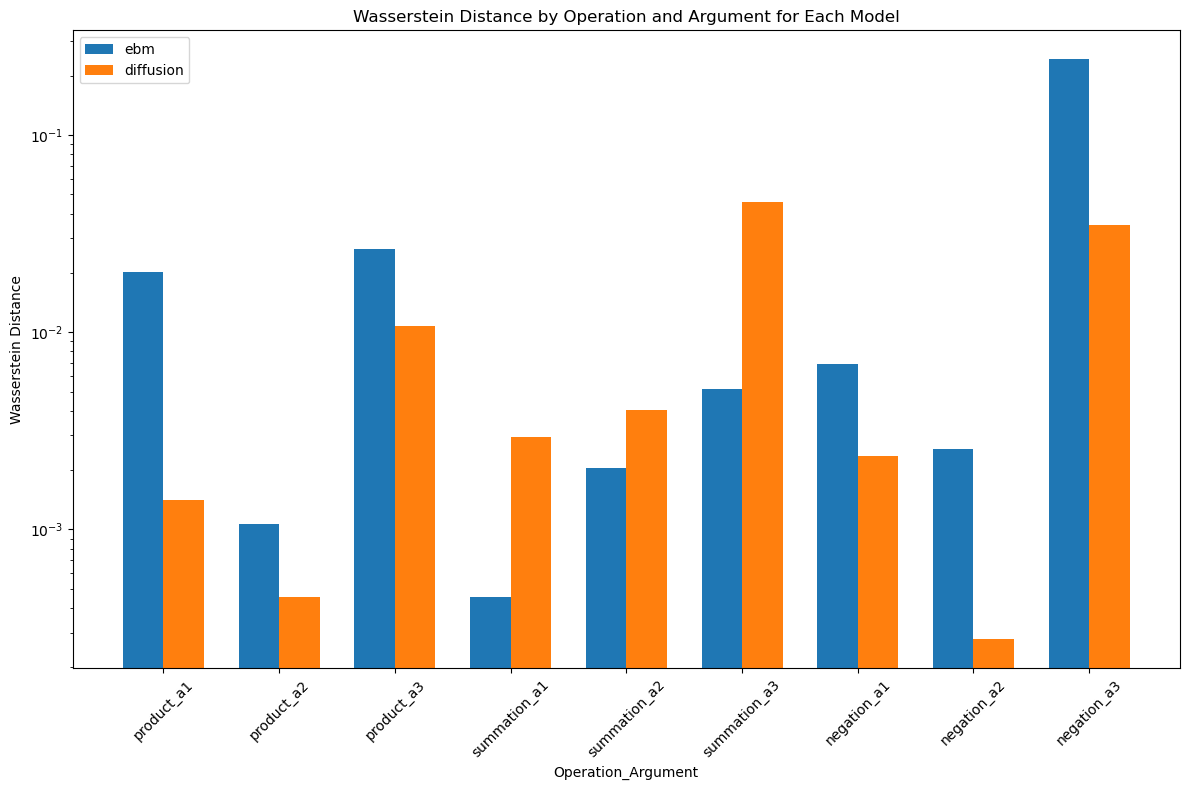

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv("exps/baselines.csv")

# Convert 'wasserstein_2_distance' column to float
df['wasserstein_2_distance'] = df['wasserstein_2_distance'].astype(float)

# Combine 'operation' and 'argument' columns
df['op_arg'] = df['operation'] + '_' + df['argument']

# Get unique combinations of operation and argument
unique_combinations = df['op_arg'].unique()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define width for each group of bars
bar_width = 0.35

# Define index for each group
index = np.arange(len(unique_combinations))

# Plot bars for 'ebm'
ax.bar(index - bar_width/2, df[df['model_name']=='ebm']['wasserstein_2_distance'], bar_width, label='ebm')

# Plot bars for 'diffusion'
ax.bar(index + bar_width/2, df[df['model_name']=='diffusion']['wasserstein_2_distance'], bar_width, label='diffusion')

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(unique_combinations, rotation=45)

# Set labels and title
ax.set_xlabel('Operation_Argument')
ax.set_ylabel('Wasserstein Distance')
ax.set_title('Wasserstein Distance by Operation and Argument for Each Model')
ax.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

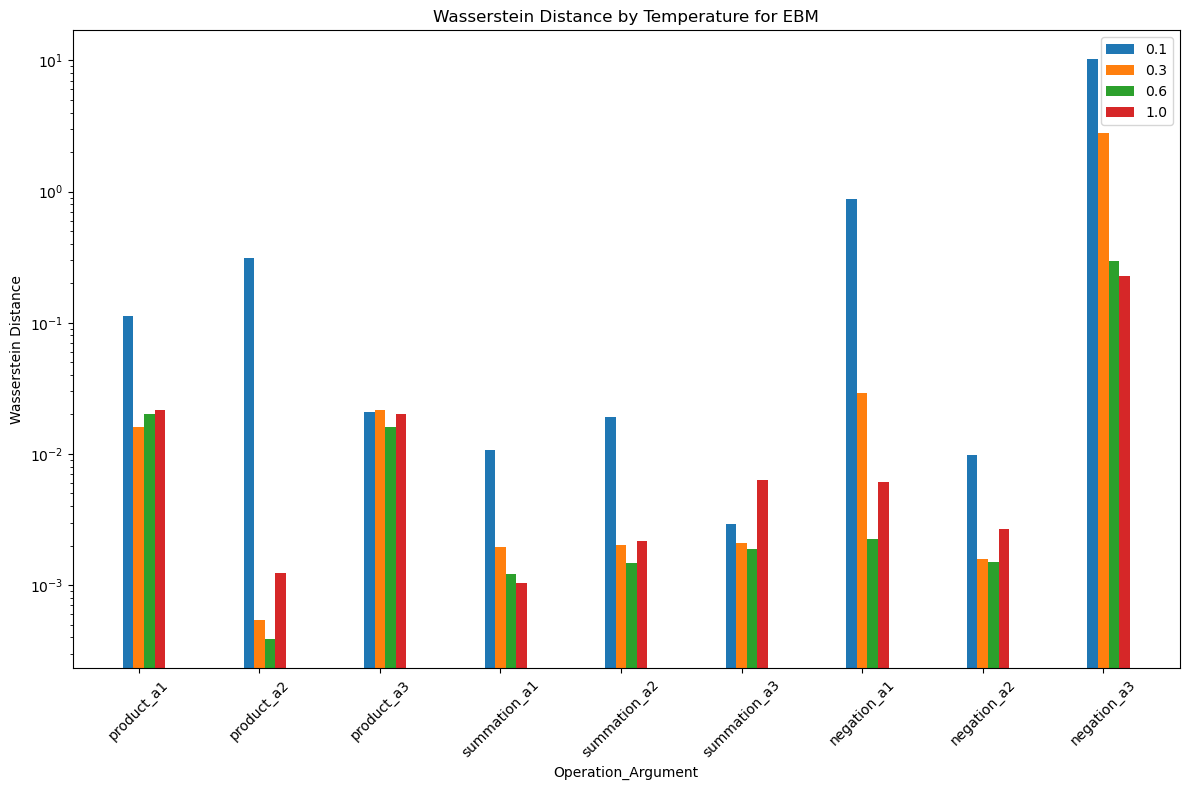

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv("exps/temperatures.csv")

# Convert 'wasserstein_2_distance' column to float
df['wasserstein_2_distance'] = df['wasserstein_2_distance'].astype(float)

# Combine 'operation' and 'argument' columns
df['op_arg'] = df['operation'] + '_' + df['argument']

# Get unique combinations of operation and argument
unique_combinations = df['op_arg'].unique()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define width for each group of bars
bar_width = 0.35

# Define index for each group
index = np.arange(len(unique_combinations))

for i, temperature in enumerate([0.1, 0.3, 0.6, 1.0]):
    ax.bar(index + (i+1) * bar_width/4 - bar_width/2, df[df['temperature']==temperature]['wasserstein_2_distance'], bar_width/4, label=temperature)

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(unique_combinations, rotation=45)

# Set labels and title
ax.set_xlabel('Operation_Argument')
ax.set_ylabel('Wasserstein Distance')
ax.set_title('Wasserstein Distance by Temperature for EBM')
ax.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

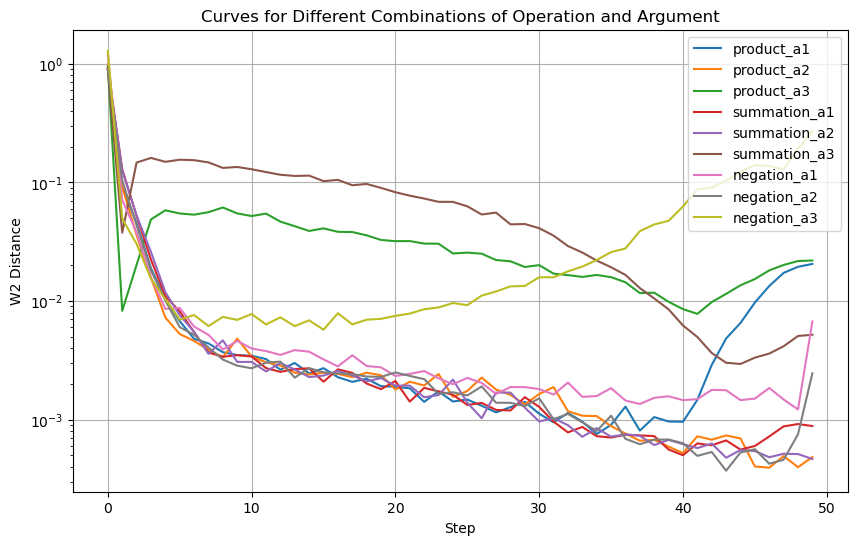

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Read the CSV file into a DataFrame
df = pd.read_csv("exps/timesteps.csv")

# Combine 'operation' and 'argument' columns
df['op_arg'] = df['operation'] + '_' + df['argument'].astype(str)

# Get unique combinations of operation and argument
unique_combinations = df['op_arg'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Iterate over unique combinations
for combination in unique_combinations:
    # Filter the dataframe for the current combination
    df_comb = df[df['op_arg'] == combination]
    
    # Ensure there is data to plot
    if not df_comb.empty:
        plt.plot(df_comb['timestep'], df_comb['wasserstein_2_distance'], label=combination)

# Add title and labels
plt.title('Curves for Different Combinations of Operation and Argument')
plt.xlabel('Step')
plt.ylabel('W2 Distance')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()